# CQF Final Project

Author: William Phoon\
Cohort: June 2024\
Topic: Pairs Trading Strategy Design & Back test (TS)  


&nbsp;


## Preface

This is the analytical report for my CQF June 2024 Final Project submission on Pairs Trading (TS).

There is an accompanying Jupyter Notebook (*pairs_trading_strategy.ipynb*) containing charts and tables. The purpose of the accompanying Jupyter Notebook is to provide a reader-friendly front-end for the Pairs Trading Python code written. The accompanying Notebook is written in the same order as the report and references to the Notebook are always tagged accordingly via *[Notebook Reference]*. The accompanying Notebook provides instructions on how to run the code.

The underlying Python files have also been provided. Classes and functions should have sufficient documentation and it should be intuitive to follow the flow of logic through the code.

File reconciliation:
- *TS_William_Phoon.pdf* - project report in pdf type
- *TS_William_Phoon.html* - project report in html type for a cleaner reading experience
- *pairs_trading_strategy.ipynb* - interactive Jupyter Notebook to pragmatically run code
- *pairs_trading_strategy.html* - html Jupyter Notebook to inspect code outputs
- *augmented_dickey_fuller.py* - Python module for ADF test
- *bivariate_engle_granger.py* - Python module for Engle Granger procedure
- *multivariate_linear_regression.py* - Python module for multivariate linear regression
- *timeseries_data.py* - Python module for bulk data extraction
- *utils.py* - Python module for utilities
- *vector_autoregressive_model.py* - Python module for VAR model
- *sp_500.db* - database containing bulk data extraction outputs

&nbsp;


## Introduction

Pairs trading is a type of trading strategy falling under statistical arbitrage. 

The strategy begins with finding a cointegrated relationship between a basket of securities. A cointegrated relationship is one where taking a linear combination of the securities results in a spread timeseries that is stationary. The weak-sense definition of stationarity is sufficient here - it has 3 conditions, namely:

1. Mean of the timeseries is constant and does not change with time.
2. Standard deviation of the timeseries is constant and does not change with time.
3. Seasonality is not exhibited by the timeseries.

Raw prices are not stationary, however returns are indeed stationary. Notice that the former is differenced once in order to obtain the latter. Accordingly, we state that prices are an I(1) process meaning Integrated of Order 1, as it takes differencing prices once in order to obtain a stationary I(0) series, namely its returns.

Locating a cointegrated relationship can be done in various ways and exist in securities such as stocks, ETFs, futures, rates and commodities. Correlation heatmaps can be assessed to give a first order insight into potentially strongly cointegrated securities. Alternatively, event-driven situations such as mergers and acquisitions can drive a significant cointegrated relationship.

This report will focus on bivariate cointegration, hence the name Pairs Trading. *Part I* focusses on pairs trade design. Here, we implement the Engle Granger procedure which consists of 2 steps, and we then append a third step where an Ornstein-Uhlenbeck stochastic differential equation (SDE) is used to fit the mean reversion. Bounds are then defined in order to create entry / exit trading signals. *Part II* focusses on backtesting the pairs trading strategy. Both parts consider 3 different pairs. 

Details of implemented methods follow *Part II*. Appendices are then appended.


&nbsp;


## Part I - Pairs Trade Design

### Economic Approach

For our first pairs trade strategy design, we consider economic reasons for cointegration to exist. Economic reasons entail companies that are competitors in the same industry - we shall consider the global payments industry. Two of the strongest players in this industry are Visa and Mastercard, who have both been around since ~1960s. We use this economic rationale to check whether Visa and Mastercard produce a cointegrated spread from start of 2020 to end of 2024. Whilst it may seem that this pair was plucked out of thin air, subsequent pairs will be found via a more formal quantitative approach. 

We begin with the Engle Granger procedure, of which the standard process comprises two steps. Step (1) of the procedure is to regress the price of asset A ($P_t^A$) on price of asset B ($P_t^B$) and then test the fitted residual for stationarity by the Cointegrated Augmented Dickey-Fuller (CADF) test. We proceed with step (2) if the residual is deemed stationary by the CADF test. Here, we confirm the Error Correction Model (ECM) and the significance of the long-run error correction coefficient, i.e. the significance of the speed of mean reversion. Separate to the standard Engle Granger procedure, we conclude the pairs trade design process with step (3) where we use the Ornstein-Uhlenbeck stochastic differential equation (OU SDE) to evaluate mean reversion. Each of these steps will be explained in finer detail.

### Step 1 - Engle Granger

The first step in Engle Granger is to regress $P_t^A$ on $P_t^B$. Let us define ticker A as Visa (V) and ticker B as Mastercard (MA). Of course, this requires us to have the price time series and so we prepare an instance of the *BivariateEngleGranger* self-implemented class to help us. The accompanying Jupyter Notebook illustrates this code in *[Notebook Reference 1.0]*. We consider whether there is a cointegrating relationship between Visa and Mastercard from 2020 till now. We then use yfinance to pull the daily close price time series over this period and we then normalise both timeseries to begin at 1. It is standard to normalise these timeseries in preparation for stationarity tests. 

Now that we have our price timeseries, we naively linearly regress $P_t^V$ on $P_t^{MA}$. We include a constant (C) in the regression.

$$ P_t^V  = C + \beta_C P_t^{MA} + e_t$$

Our linear regression finds a value for the constant, $C$, and the coefficient for MA price, $\beta_C$. The linear regression minimises the squared error, also known as Ordinary Least Squares (OLS). *[Notebook Reference 1.1]* details the linear regression code, which uses the self-implemented class *MultivariateLinearRegression*. OLS states that if $X$ is our feature matrix and $Y$ is our target matrix, our least squares estimate for $B$ is:

$$ \widehat{B} = (X^TX)^{-1}X^TY \text{ where } Y = X B + e$$

There are choices when it comes to self-implementing the least squares estimate for $B$. It is preferred to avoid directly computing $(X^TX)^{-1}$, as it is computationally expensive and more unstable to directly compute an inverse. Rather, we use *numpy.linalg.solve* to avoid unnecessary computations as it is optimized for solving linear systems therefore making it faster for large matrices. Other methods to approach this problem include LU decomposition, Cholesky decomposition and QR decomposition.

Note that $Y$ can be a matrix as this is in the multivariate world. We can rearrange the regression to find a formula for the fitted residual/error/spread.

$$ \hat{e}_t = P_t^V - \beta_C P_t^{MA} - C$$

From the least squares estimate $ \widehat{B} $, we take our coefficient for price of MA and call this $\beta_C$. We then define our cointegrating vector ($B_{Coint}$) which is long 1 Visa and short $\beta_C$ Mastercard (post normalisation). This means we have a long/short portfolio with weights given by $B_{Coint}$.

$$ B_{Coint} = \begin{bmatrix} 1 \\ -\beta_C \end{bmatrix} $$

The regression summary table is detailed below. The second row pertains to $\beta_C$ hence we see that $\beta_C = 0.840386$. Also included in the summary table is the standard error, t-statistic and the associated p-value (assuming t-distribution). Under a 5% significance level hypothesis testing setup, we see that both p-values are under 5% hence both coefficients are statistically significant i.e. do not equal 0.


In [24]:
"""
(1) View > Cell Toolbar > Edit Metadata

(2) add hide_input tag in metadata
{
  "tags": ["hide_input"]
}

(3) export to html with exclude_input
run in anaconda prompt in corrrect directory
jupyter nbconvert --to html --TemplateExporter.exclude_input=True TS_William_Phoon.ipynb
"""
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
import warnings

from bivariate_engle_granger import BivariateEngleGranger
from vector_autoregressive_model import VectorAutoRegressiveModel

warnings.filterwarnings('ignore')

""" Notebook Reference 1.0 """

# Create Bivariate Engle Granger class 
EG = BivariateEngleGranger()

# Initialise first pair based on economic reasoning for cointegration to exist (Visa on Mastercard)
ticker_a = "V"
ticker_b = "MA"
start_date = "2020-01-01"
end_date = "2024-11-29"
benchmark = "^SPX"

EG.initialise_single_procedure(ticker_a, ticker_b, start_date, end_date, benchmark=benchmark)

# Get close prices from yfinance
EG.get_close_prices_timeseries()

# Normalise timeseries
EG.normalise_bivariate_timeseries()

""" Notebook Reference 1.1 """

# Naive regression of timeseries
EG.regress_timeseries(include_constant=True)


Regressand Regressor  Coefficient  Standard Error  t-statistic  \
0          V  Constant     0.161250        0.005852    27.554876   
1          V        MA     0.840386        0.004655   180.553369   

   p-value (t-dist)  
0               0.0  
1               0.0

An alternative method to the naive linear regression is to use PCA. We could use PCA to find the First Principal Component (PCA1) which we would then use as our hedging weights vector.

Following the linear regression, it is useful to look at the four plots below, which are coded in *[Notebook Reference 1.2]*. We read the plots from left to right. The first plot, *Raw Prices*, shows raw close prices and this is the unadjusted timeseries extracted from yfinance. The second plot, *Normalised Prices*, normalises both time series to start at 1. The third plot, *Regressed Prices*, plots the normalised timeseries with Mastercard under the regression transformation. It is useful to visually note that the two timeseries sit more nicely on top of one another in *Regressed Prices* than *Normalised Prices*. 

Finally, the fourth plot *Residual* illustrates the residual/error timeseries owing to the linear regression. This residual is what we would like to test for stationarity and ultimately see if we can produce a mean-reverting trading strategy from. From just inspecting visually, we can see that it likely satisfies the constant mean property of weak-sense stationarity. We cannot however just visually inspect - rather, we use the CADF stationarity test for increased rigour.

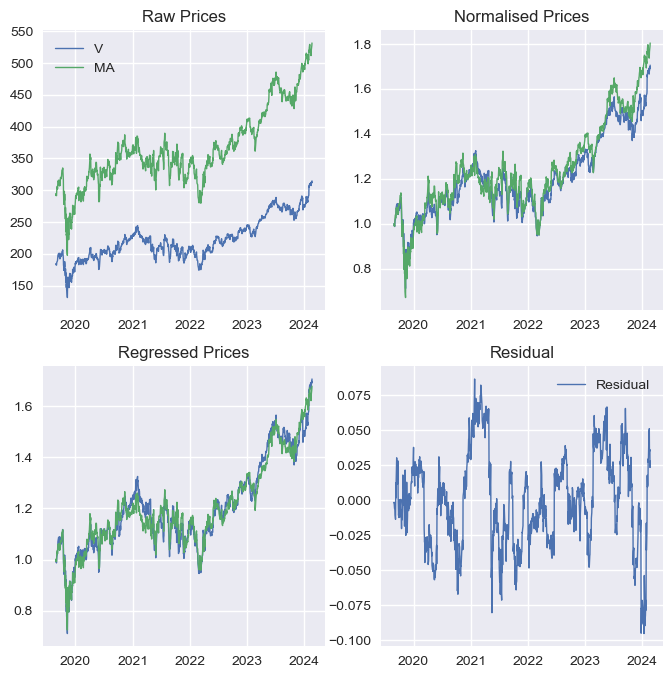

In [2]:
EG.plot_timeseries()

The Dickey-Fuller (DF) test tests if a timeseries is stationary as it is a formal test for a unit root. Presence of a unit root means that the timeseries is a random walk with drift, which clearly does not have a constant mean. Let $y_t$ denote the timeseries at time t. The Dickey-Fuller test has the following test equation:

$$ \Delta y_t = \phi y_{t-1} + e_t $$

Null Hypothesis $H_0 : \phi = 0$ means that a unit root is present and $y_t$ is non-stationary.\
Alternative Hypothesis $H_1 : \phi \not= 0$ means that a unit root is not present and $y_t$ is stationary.

A regression is performed in order to obtain $\phi$ and $\phi$'s test statistic is compared in the hypotheses. The test statistic is $\frac{\phi}{SE_{\phi}}$, where $SE_{\phi}$ is the standard error of $\phi$. The nuance with the Dickey-Fuller test is that the critical value is derived from the Dickey-Fuller distribution. This distribution was generated via Monte Carlo simulations, and it is now standard to use MacKinnon's approximation to the Dickey-Fuller distribution. Mackinnon's approximation is calculated at the 1%, 5% and 10% significance level and is given by:

$$ \beta_{\infty} + \frac{\beta_{1}}{n} + \frac{\beta_{2}}{n^2} + \frac{\beta_{3}}{n^3} $$

The latest values for $\beta$ are found in MacKinnon's 2010 tables and n is the number observations used to fit the regression. If the test statistic for $\phi$ is less than the critical value, the null hypothesis is rejected and the timeseries is deemed stationary at that significance level i.e. we take the alternative hypothesis.

The Augmented Dickey-Fuller (ADF) test improves on the DF test by including lagged differences in the regression which allows for autocorrelation in differences. These terms are added to correct for higher order serial autocorrelation in the residuals of the underlying model. The Augmented Dickey-Fuller test equation is:

$$ \Delta y_t = \phi y_{t-1} + \sum_{k=1}^{p} \phi_i \Delta y_{t-k} + e_t $$

Lastly, the Cointegrated Augmented Dickey-Fuller (CADF) test is used to test for cointegration between two or more non-stationary timeseries. This is different from the ADF test which is used to check if a single time series is stationary or has a unit root. The number of non-stationary timeseries testing for cointegration is important as this is used to determine which MacKinnon $\beta$ approximation table to use.

It is possible to include various other terms in the CADF test equation, such as a constant, trend term ($\phi_t t$) or a quadratic trend term ($\phi_{t^2} t^2$). We include only the constant term as the trend terms can make one think cointegration exists when it is in fact very weak.

We test for stationarity of the residual using the CADF test. The number of I(1) series used to test for cointegration is two. Also recall that we include lagged differences in regression - for this exercise we set lag equal to 1. Additionally, we include a constant term. Taking this all into account, this means our test equation for the cointegrated residual (let this be $y_t$ just for this notation) is:

$$ \Delta y_t = C + \phi y_{t-1} + \phi_1 \Delta y_{t-1} + e_t $$

We run a regression on this test equation for the cointegrated residual and consider the coefficient for $y_{t-1}$ i.e. $\phi$ itself. We compute the test statistic for $\phi$ given by $\frac{\phi}{SE_{\phi}}$ and verify if it is less than the associated Dickey-Fuller critical value at the 1%, 5% and 10% significance level. If the test statistic is less than the Dickey-Fuller critical value, we reject the null hypothesis and declare that the cointegrated residual is stationary at the respective significance level. 

The CADF stationary test is run in *[Notebook Reference 1.3]*. The regression has been run on the test equation and then the regressor for $y_{t-1}$ has been abstracted out to compare it at the 1%, 5% and 10% significance levels. This is summarised in the following table (and in *[Notebook Reference 1.3]* output).

In [3]:
""" Notebook Reference 1.3 """

# Check for stationarity of residual using Cointegrated Augmented Dickey-Fuller test
EG.is_residual_stationary(cadf_include_constant=True)

Regressand          Regressor  t-statistic Significance Level  \
0  ΔResidual  (Lag 1, Residual)    -4.274682                 1%   
1  ΔResidual  (Lag 1, Residual)    -4.274682                 5%   
2  ΔResidual  (Lag 1, Residual)    -4.274682                10%   

   Critical Value  Is Stationary  
0       -3.905337           True  
1       -3.341086           True  
2       -3.047889           True

We observe that the test statistic is less than the Dickey-Fuller critical value at all significance levels. Therefore we reject the null hypothesis and determine that the Visa on Mastercard residual is stationary at the 1% significance level. It is worth noting that the t-statistic is moderately less than the 1% critical value - this supplies somewhat of a proxy for how strong the stationarity is. Conducting this test provides a rigorous confirmation of our visual observation regarding the stationarity of the residuals.

### Step 2 - Engle Granger

Now that we have confirmed stationarity of the residuals, we proceed with Step 2 of the Engle Granger procedure. This involves constructing the Error Correction Model (ECM). Suppose our timeseries is $y_t$, then the ECM provides a formula for the change in $y_t$ (i.e. $\Delta y_t$). This relationship comprises of both a short run and long run relationship. The ECM states that the following two equations are equivalent:

$$ y_t = \alpha y_{t-1} + \beta_0 + \beta_1 x_t + \beta_2 x_{t-1} + e_t $$

$$ \Delta y_t = \beta_1 \Delta x_t - (1-\alpha) (y_{t-1} - a - b x_{t-1}) + e_t $$

In the context of our Visa on Mastercard investigation, this is equivalent to:

$$ \Delta P_t^V = \phi \Delta P_t^{MA}  - (1 - \alpha) (P_{t-1}^V - \beta_C P_{t-1}^{MA} - C) = \phi \Delta P_t^{MA}  - (1 - \alpha) (e_{t-1}) $$

For a change in price of Visa (i.e. $\Delta P_t^V$), the term $\phi \Delta P_t^{MA}$ represents the short run relationship and the term $(P_{t-1}^V - \beta_C P_{t-1}^{MA} - C)$ represents the long run relationship. Notice that the long run relationship is simply the lagged error $e_{t-1}$. 

$-(1-\alpha)$ is the coefficient of the long run relationship and therefore represents the speed of long run mean reversion. The purpose of this step in the Engle Granger procedure is to confirm the significance of the Error Correction term. We do this by confirming that its coefficient $-(1-\alpha)$ is statistically significant and therefore statistically different from 0. 

Since we have the raw price series for Visa and Mastercard, it is easy to difference both series to obtain $P_t^i$. We also have the error/residual so it easy to lag this by 1. This gives us all the terms we require to perform the regression. *[Notebook Reference 1.4]* performs the Error Correction Model regression and the regression summary table is below.

In [4]:
""" Notebook Reference 1.4 """

# Fit error correction model and confirm significance of reversion speed term
EG.check_error_correction_model_mean_reversion()

Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0         ΔV                 ΔMA     0.795029        0.011609    68.481687   
1         ΔV  (Lag 1, Residuals)    -0.033085        0.007332    -4.512335   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000007               True

We observe that both terms are statistically significant. We also see that the lagged residuals have a coefficient of -0.033085 meaning that $\alpha = 0.966915$. The p-value for the lagged residuals is far below 5% meaning that the long run error correction is statistically significant (and significantly different from zero) at the 5% level. This is because we reject $H_0$ that a regression coefficient is zero if the corresponding p-value is less than a chosen significance level. Note that the p-value is calculated from the t-distribution and not from the Dickey-Fuller distribution. 

The significance of the Error Correction term ensures correction in the long run equilibrium. Consider the Error Correction term $e_{t-1} = (P_{t-1}^V - \beta_C P_{t-1}^{MA} - C)$ which is simply the difference in prices at $t-1$. If $P_{t-1}^V > \beta_C P_{t-1}^{MA} + C \leftrightarrow -(1-\alpha) e_{t-1} < 0$ meaning that $ P_t^V $ has a downward force from the Error Correction term. In words, if Visa is overvalued compared to Mastercard the following period will try to correct for that and reduce the increase in Visa price. This mechanic is the long run Error Correction. 

This correction still holds vice versa, namely if $P_{t-1}^V < \beta_C P_{t-1}^{MA} + C \leftrightarrow -(1-\alpha) e_{t-1} > 0$ meaning that $ P_t^V $ has an upward force from the Error Correction term.

The Error Correction term should not stay the same in each period. This is evident as the Error Correction term is just the residual multiplied by the speed of mean reversion. We know that the latter is constant in our model. We can also visually confirm that the residual jumps around a particular level whilst mean reverting. Therefore, the product of the two terms would result in a timeseries that does not stay the same in each period. We would expect the Error Correction term to exhibit positive/negative signage clustering. 

For further checking, we should estimate the ECM for Mastercard on Visa with the current reisudals. This does mean that the residuals will effectively be the *wrong way* round. Explicitly, we will be regressing the following:

$$ \Delta P_t^{MA} = \phi \Delta P_t^{V}  - (1 - \alpha) (P_{t-1}^V - \beta_C P_{t-1}^{MA} - C) $$

Notice that the error correction term is the same as before - this is why the residuals are seen as *wrong way* residuals. We now regress as in *[Notebook Reference 1.5]* and confirm the significance of the Error Correction term.

In [5]:
""" Notebook Reference 1.5 """

# Check "wrong way round" residual 
EG.check_error_correction_model_mean_reversion(reverse_regression=True)

Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0        ΔMA                  ΔV     0.995962        0.014543    68.481687   
1        ΔMA  (Lag 1, Residuals)     0.036321        0.008209     4.424496   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000011               True

Again, notice that the lagged residuals are indeed significant at the 5% significance level so we say that the Error Correction term is significantly different from zero. 

There remains another checking step whereby we re-estimate the entire residual for Mastercard on Visa. In particular, we would go through the entire process up to this point. We begin with the regression of Mastercard on Visa which will be of the form:

$$ P_t^{MA}  = C' + \beta_{C'} P_t^{V} + e_t'$$

*[Notebook Reference 1.6]* performs this process and all outputs are as follows.

Price regression summary


Regressand Regressor  Coefficient  Standard Error  t-statistic  \
0         MA  Constant    -0.139631        0.007724   -18.076520   
1         MA         V     1.146529        0.006350   180.553369   

   p-value (t-dist)  
0               0.0  
1               0.0



Timeseries plots


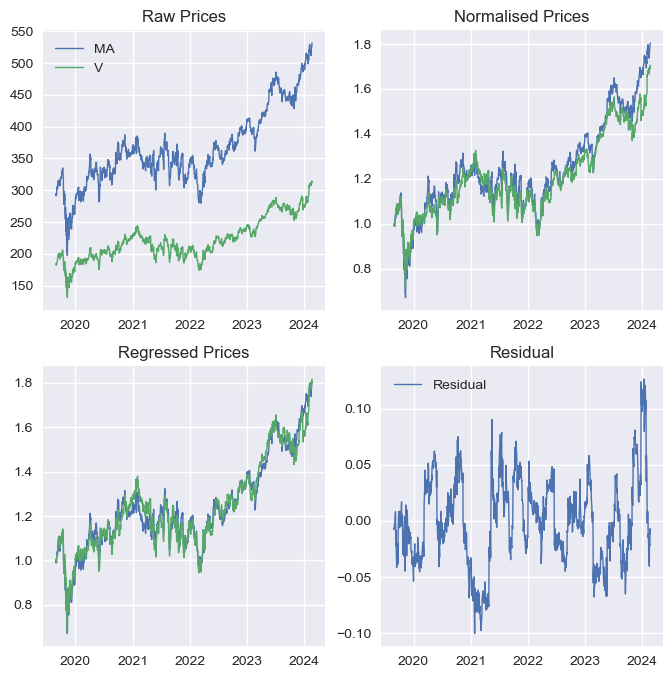



Cointegrated Augmented Dickey-Fuller test


Regressand          Regressor  t-statistic Significance Level  \
0  ΔResidual  (Lag 1, Residual)     -4.30584                 1%   
1  ΔResidual  (Lag 1, Residual)     -4.30584                 5%   
2  ΔResidual  (Lag 1, Residual)     -4.30584                10%   

   Critical Value  Is Stationary  
0       -3.905337           True  
1       -3.341086           True  
2       -3.047889           True



Error Correction Model fitting


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0        ΔMA                  ΔV     0.995669        0.014539    68.480959   
1        ΔMA  (Lag 1, Residuals)    -0.031325        0.007024    -4.459390   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000009               True



Error Correction Model reverse fitting


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0         ΔV                 ΔMA     0.795260        0.011613    68.480959   
1         ΔV  (Lag 1, Residuals)     0.028031        0.006278     4.465154   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000009               True



CADF stationarity test has a stronger t-statistic for MA on V (-4.305842 vs -4.274683)


In [6]:
""" Notebook Reference 1.6 """

# Re-estimate the other way round (MA on V) and follow same procedure
EG_reverse = BivariateEngleGranger()

EG_reverse.initialise_single_procedure(ticker_b, ticker_a, start_date, end_date, benchmark=benchmark)

EG_reverse.get_close_prices_timeseries()

EG_reverse.normalise_bivariate_timeseries()

print("Price regression summary")
display(EG_reverse.regress_timeseries(include_constant=True))

print("\n\nTimeseries plots")
EG_reverse.plot_timeseries()

print("\n\nCointegrated Augmented Dickey-Fuller test")
display(EG_reverse.is_residual_stationary(cadf_include_constant=True))

print("\n\nError Correction Model fitting")
display(EG_reverse.check_error_correction_model_mean_reversion())

print("\n\nError Correction Model reverse fitting")
display(EG_reverse.check_error_correction_model_mean_reversion(reverse_regression=True))

print("\n\nCADF stationarity test has a stronger t-statistic for MA on V (-4.305842 vs -4.274683)")

When we regress Mastercard on Visa, we see that the hedging ratio for Visa is 1.146530 i.e. $\beta_{C'}=1.146530$. This means that we have $ B_{Coint'} = \begin{bmatrix} 1 & -1.146530 \end{bmatrix}^T $. We also see that the cointegrated residual is given by our naive regression is:

$$ P_t^{MA}  = C' + \beta_{C'} P_t^{V} + e_t' = -0.139631 + 1.146530 P_t^{V} + e_t' $$

We also see that the resulting residual is stationary by the CADF test. In fact, the test statistic for the CADF test displays stronger stationarity under this setup as -4.305842 is less than -4.274683. 

The ECM fitting and ECM reverse fitting both display significance for the long run equilibrium correction under this setup as well.

__Given the stronger stationarity displayed by regressing Mastercard onto Visa, we shall now treat this setup as our base case going forwards and drop the $'$ annotation accordingly.__

### Step 3 - Mean-Reversion Evaluation

We extend the standard Engle Granger procedure with a third step where we evaluate the mean-reversion by fitting it to the Ornstein-Uhlenbeck Stochastic Differential Equation (OU SDE). The aim of fitting the stationary residual ($e_t$) to the OU SDE is to get parameters for the mean and standard deviation of the residual, which we call $\mu_e$ and $\sigma_{eq}$ respectively. Defining these parameters allows for pairs trade design where we enter on bounds $\mu_e \pm Z \sigma_{eq}$ and exit on reversion to level $\mu_e$. Namely, when the residual deviates significantly away from $\mu_e$, it produces a trading signal.

We can illustrate this signal generation mathematically. Recall that the strategy trades a long/short portfolio with weights given by $B_{Coint}$. The trading signals generated are:

- When $ e_t < \mu_e - Z \sigma_{eq} $ we *buy the spread* and enter a trade with assets weighted by $B_{Coint}$ i.e. 
$
\begin{bmatrix} P^A \\ -\beta_C P^B \end{bmatrix} = 
\begin{bmatrix} P^{MA} \\ -\beta_C P^V \end{bmatrix} = 
\begin{bmatrix} P^{MA} \\ -1.147105 P^V \end{bmatrix}
$
- When $ e_t > \mu_e + Z \sigma_{eq} $ we *short the spread* and enter a trade with assets weighted by $-B_{Coint}$ i.e. 
$
\begin{bmatrix} -P^A \\ \beta_C P^B \end{bmatrix} = 
\begin{bmatrix} -P^{MA} \\ \beta_C P^V \end{bmatrix} = 
\begin{bmatrix} -P^{MA} \\ 1.147105 P^V \end{bmatrix}
$

Plots are generated later in this section to visually depict the trading strategy.

The OU SDE we fit the cointegrated residual ($e_t$) to is given by:

$$ de_t = -\theta (e_t - \mu_e)dt + \sigma_{OU}dX_t $$

Here, $-\theta$ is the speed of reversion to the equilibrium level $\mu_e$. Notice that $\sigma_{OU}$ is different from $\sigma_{eq}$. The former is the total diffusion and the one we insert into the OU SDE. The latter is the diffusion that regulates the bounds of mean reversion and hence the trading entry signals. 

To begin the OU SDE fitting, we first run an AutoRegressive Order 1 i.e. AR(1) regression on the cointegrated residual. *[Notebook Reference 1.7]* provides the code for this and handles the derivation of $\mu_e$ and $\sigma_{eq}$. The AR(1) regression of the cointegrated residual uses the self-implemented class *VectorAutoRegressiveModel*. This class can handle both VAR and AR regressions with a specified amount of lags.

$$ e_t = C + B e_{t-1} + \epsilon_t $$

Here, $C$ and $B$ are constants for the AR(1) regression and are different from the terms defined in earlier regressions. 

Now, we define $\tau = \frac{1}{252}$ as we are working with daily timestep data.

We then define the speed of mean reversion as $\theta = -\frac{\ln B}{\tau}$. 

We then define the half-life in years as $H = \frac{\ln(2)}{\theta}$.

We can then compute the half-life in working days as $\frac{H}{\tau}$.

We then define the equilibrium level of the residual as $\mu_e = \frac{C}{1-B} $.

The speed of mean reversion and residual equilibrium level have now been found, and we can focus on obtaining the diffusion terms.

We define OU SDE diffusion over each small $dt$ as: 

$$ \sigma_{OU} = \sqrt{\frac{2 \theta SSE}{1 - e^{-2 \theta \tau}}} $$

where $SSE$ is the sum squared errors from the AR(1) regression of the residual timeseries.

We then have a relationship between the diffusion terms given by $ \sigma_{OU} = \sigma_{eq} \sqrt{2 \theta} $.

More explicitly, we define $\sigma_{eq}$ as:

$$\sigma_{eq} = \sqrt{\frac{Var[\epsilon_t]}{1 - e^{-2 \theta \tau}}} = \sqrt{\frac{SSE \times \frac{\tau}{T}}{1 - e^{-2 \theta \tau}}} $$

where the numerator inside the square root represents the annualised variance.

All these calculations are executed in *[Notebook Reference 1.7]* and the output is the following.

In [7]:
""" Notebook Reference 1.7 """

# Fit residual to Ornstein Uhlenbeck stochastic differential equation
EG_reverse.fit_to_ornstein_uhlenbeck_sde()

Theta: 8.6089

Half-life in years: 0.0805 years
Half-life in working days: 20.2897 days

Equilibrium level μ_e: -0.000103878766477216
Equilibirum level μ_e can be compared to the AR(1) fitting intercept: -3.4888223429128223e-06

Sum Squared Errors: 0.12443603472379597

Annualised Variance: 0.0004937937885864919
Diffusion in Ornstein-Uhlenbeck SDE (sigma_ou): 0.35879727104509923
Diffusion in equilibrium to dictate entry trade signals (sigma_eq): 0.08646876257396059

Diffusion of sample residuals (note the difference): 0.010037824607616735


Also included in this output are comparisons between (i) the equilibrium level and diffusion and (ii) simpler methods of calculating a comparable metric. 

Firstly, we compare the calculated equilibrium level $ \mu_e $. This is the equilibrium level of the cointegrated residual and will be the level at which we exit our pairs trade. $ \mu_e $ is comparable to the AR(1) fitting intercept, namely $C$. We see that both values are effectively zero.

Next, we compare the diffusion in equilibrium, $\sigma_{eq}$, which dictates entry trade signals. $\sigma_{eq}$ is comparable to the standard deviation of the residual time series. We note that the former is greater than the latter, meaning that fitting the residual to an OU process gives wider bounds for trade signals.

We see a half life equivalent to 20.2 working days.

### Trade Design

Now that we have obtained $\mu_e$ and $\sigma_{eq}$, we can explicate our trade design:

- We enter on bounds $\mu_e \pm Z \sigma_{eq} = -0.0001039 \pm Z \times 0.08647$

- We exit on mean-reversion to the equilibrium level $\mu_e = -0.0001039$

The plot below illustrates the residual plot, found in *[Notebook Reference 1.8]*. The equilibrium residual level $\mu_e$ is the green dashed line; the upper bound $\mu_e + Z \sigma_{eq}$ is the red dashed line; the lower bound $\mu_e - Z \sigma_{eq}$ is the orange dashed line. For this plot, we have simply assumed Z=0.7. The trading signals are therefore when the residual crosses one of these dashed lines.

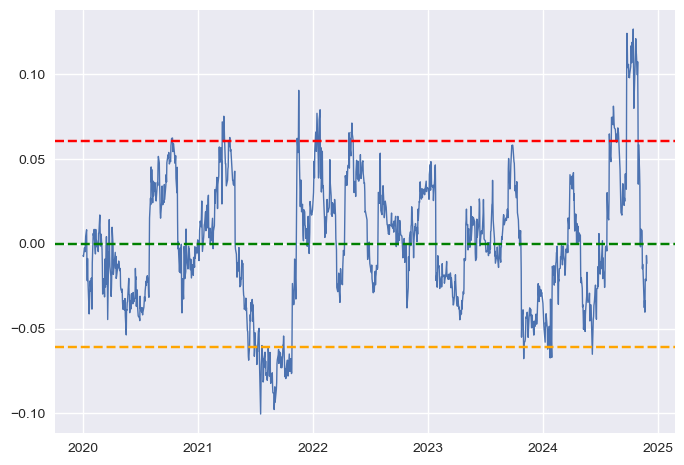

In [8]:
""" Notebook Reference 1.8 """

warnings.filterwarnings('ignore')

# Create backtest for z=0.7
backtest = EG_reverse.create_backtest_for_z(0.7)

# Plot residual and trading bounds
EG_reverse.plot_backtest(backtest, trade_markers=False)

Before we begin the next step of optimising for $Z$, it is important to go over the assumptions/methodology of the trading strategy. We assume that trading of the residual occurs at the end of day only. Therefore, the price at which we trade the spread will not exactly line up with $\mu_e$ and $\mu_e \pm Z \sigma_{eq}$. This has an upwards effect on the strategy return because we buy the spread at a cheaper price and conversely short the spread at a higher price. Furthermore, we exit the spread at a more favourable price depending on whether we are long or short spread.

The plot below illustrates this and is found in *[Notebook Reference 1.9]*:

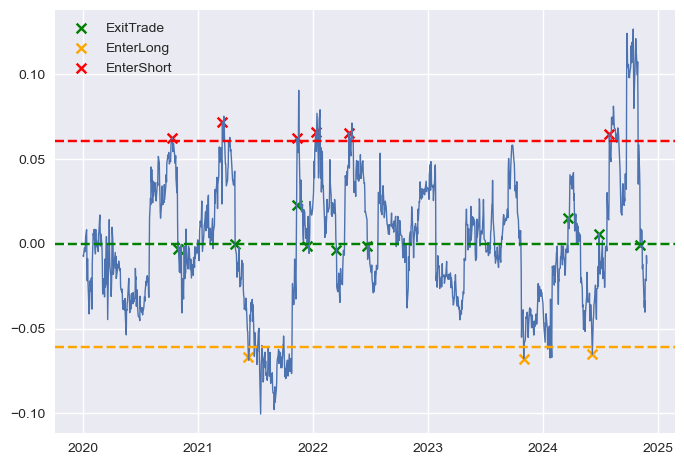

In [9]:
""" Notebook Reference 1.9 """

# Plot residual and trading bounds
EG_reverse.plot_backtest(backtest, trade_markers=True)

Rather than assuming that Z=1, we implement an optimisation to find the Z returning maximum total return. 

As a consequence of assuming that trading occurs at the end of day, there will be values of Z which return identical total return. For example, if an increase in Z results in the same number of trades, then there are instances where those trades are the exact same, and therefore the total return is identical. There are also instances where this is false, and a strategy with the same amount of trades as another strategy will have a different total return. Examples of this are found in the remaining two pairs to cover. The total return for the trading strategy is explained in full detail in *Part II - Backtesting*.

This means that total return will effectively be a step function when varying Z. We therefore cannot use methods such as gradient descent to find the maximum total return, as the gradient will be 0 everywhere apart from the steps. 

Consequently, we optimise for Z using a grid search. Our grid search varies Z from 0.3 to 1.4 in 0.05 intervals. The table below is our grid search and is produced in *[Notebook Reference 1.10]*. 

In [10]:
""" Notebook Reference 1.10 """

# Find optimal Z
z_table, df_trades = EG_reverse.optimise_trading_strategy()

z_table

Maximum return occurs with Z=0.3


Z  Total Trades  Total Return
0   0.30            27      1.510599
1   0.35            23      1.464461
2   0.40            20      1.313974
3   0.45            18      1.210178
4   0.50            15      1.094539
5   0.55            13      0.887958
6   0.60            12      0.850665
7   0.65            10      0.689993
8   0.70             9      0.664534
9   0.75             8      0.636522
10  0.80             6      0.503286
11  0.85             5      0.420748
12  0.90             4      0.368844
13  0.95             3      0.276968
14  1.00             3      0.276968
15  1.05             2      0.183243
16  1.10             2      0.183243
17  1.15             2      0.204227
18  1.20             1      0.089929
19  1.25             1      0.089929
20  1.30             1      0.089929
21  1.35             1      0.089929
22  1.40             1      0.089929

From the grid search, we see that the maximum return occurs with Z=0.3, so we shall now assume that our trading entry signals occur on $\mu_e \pm 0.3 \sigma_{eq}$. These bounds are very tight and also trades occur significantly more frequently.

From our Z table, it appears as if there is an inverse relationship with Z and total return. This relationship would not continue all the way to Z=0. At some point, decreasing the bounds to enter a trade would result in less total return. This is better illustrated in the pairs gathered from the quantitative approach (this is correlation not causation). Furthermore, with increased number of trades, we will likely encounter higher transaction costs. This model does not account for transaction costs so the total return will be overstated compared to the real world.

As we used a grid search to find Z, it could be worth exploring more precise values for Z. One way we could do this is by testing small increments/decrements in Z around Z=0.3 until we reach a different number of total trades. However, there could be an element of overfitting to this, leading to a decrease in bias but increase in variance. 

Now we have our optimal Z, we can plot the trades realised from this strategy. 

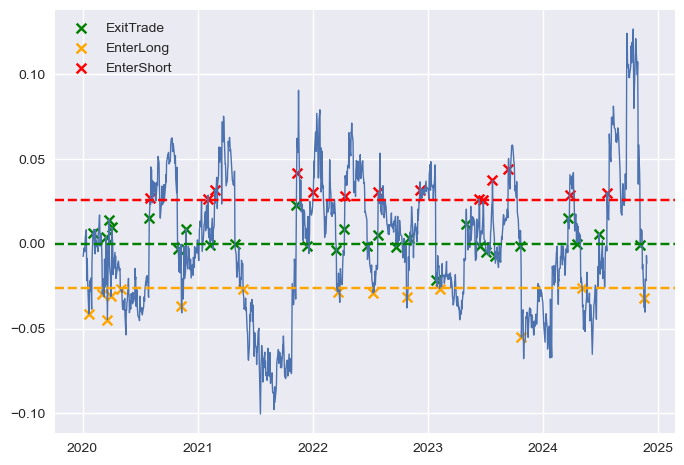

In [11]:
""" Notebook Reference 1.11 """

# Plot trades realised from strategy with optimal Z
EG_reverse.plot_backtest(df_trades, trade_markers=True)


We can see that the trading bounds are tighter and the number of trades executed is significantly higher than with Z=0.7. Backtesting of this trading strategy, including cumulative PnL is covered in *Part II - Backtesting*.

Notice that there are trades that occur a decent distance away from their respective bound. This is due to the large movements in underlying pricing on that day. Given that we assume trading occurs at end of day, there is scope for the residual to drift further onside as long as it finishes onside at end of day. 

A good example of this is at the end of 2021 where we see an exit trade very close to the enter short signal ($\mu_e + 0.3 \sigma_{eq}$). An even better example of this is on 2024-07-24 where we exit a long spread trade and enter into a short spread trade on the same day. This means that the spread moved exceptionally fast that day and travelled from below $\mu_e$ to above ($\mu_e + 0.3 \sigma_{eq}$) in the same day. 

### Vector Autoregressive Models

Before we move onto the quantitative approach, let us briefly take a step back and walk through the Vector Autoregressive Model. 

So far, we have created a trading strategy from a cointegrated spread, but what if want to try to predict future returns from past returns? Also, what if we believe that Mastercard and Visa lagged returns both influence the future returns of each stock? This is where a VAR(p) model can be used. 

A VAR(p) model is a type of autoregressive model. Autoregression means that the model uses lagged values of itself to predict future values. The "V" in VAR(p) stands for Vector and means that variables affect other variables. Lastly, p is the number of lagged values to regress with.

Let us take a simple example of VAR(1). The VAR(1) model with 3 variables $y_1, y_2, y_3$ and a constant can be expressed as:

$$
\begin{bmatrix}
y_{1,t} \\
y_{2,t} \\
y_{3,t}
\end{bmatrix}
=
\begin{bmatrix}
c_1 \\
c_2 \\
c_3
\end{bmatrix}
+
\begin{bmatrix}
\phi_{11} & \phi_{12} & \phi_{13} \\
\phi_{21} & \phi_{22} & \phi_{23} \\
\phi_{31} & \phi_{32} & \phi_{33}
\end{bmatrix}
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1} \\
y_{3,t-1}
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_{1,t} \\
\epsilon_{2,t} \\
\epsilon_{3,t}
\end{bmatrix}
$$

where:

- $y_{i,t}$ is the $i$-th variable at time $t$
- $c_i$ is the constant for the $i$-th variable
- $\phi_{ij}$ are the coefficients of the lagged variables
- $\epsilon_{i,t}$ is the error term for the $i$-th variable at time $t$

This can be expressed more concisely in block matrix form by:

$$ \mathbf{Y}_t = \mathbf{C} + \mathbf{\Phi} \mathbf{Y}_{t-1} + \mathbf{\epsilon}_t $$

We now try to answer our earlier question of exploring whether we can use past returns to predict future returns, whilst allowing variables to affect other variables. In particular, we shall continue with our 2020-24 Mastercard and Visa example and slot in the S&P500 as well. We shall take the log returns and then fit to a VAR(1) model i.e. regress "everything on everything". The output from the VAR(1) fitting is sourced from *[Notebook Reference 1.12]*.

In [12]:
""" Notebook Reference 1.12 """

# Initialise VAR class
VAR = VectorAutoRegressiveModel()

# Get dataframe of ticker close prices
close_pxs = {}
var_tickers = ["^SPX", "MA", "V"]

for ticker in var_tickers:
    close_pxs[ticker] = (yf.Ticker(ticker)
                            .history(start=start_date, end=end_date)
                            .Close)

# Merge into one dataframe
df_var = pd.DataFrame(close_pxs)
df_var.columns = var_tickers

# Take log returns
df_var = (np.log(df_var)
          .diff()
          .dropna())

# Fit to VAR model
VAR.fit(df_var, lags=1)

# Retrieve VAR fitting summary
output_var = VAR.summary()

print("VAR(1) fitting summary")
output_var

VAR(1) fitting summary


Regressand      Regressor  Coefficient  Standard Error  t-statistic  \
0        ^SPX       Constant     0.000591        0.000379     1.559996   
1        ^SPX  (Lag 1, ^SPX)    -0.176497        0.046671    -3.781730   
2        ^SPX    (Lag 1, MA)     0.143043        0.047971     2.981836   
3        ^SPX     (Lag 1, V)    -0.165603        0.052667    -3.144348   
4          MA       Constant     0.000569        0.000554     1.028173   
5          MA  (Lag 1, ^SPX)    -0.157130        0.068212    -2.303551   
6          MA    (Lag 1, MA)     0.165196        0.070113     2.356141   
7          MA     (Lag 1, V)    -0.195123        0.076975    -2.534873   
8           V       Constant     0.000535        0.000495     1.080189   
9           V  (Lag 1, ^SPX)    -0.208923        0.061003    -3.424797   
10          V    (Lag 1, MA)     0.238128        0.062703     3.797720   
11          V     (Lag 1, V)    -0.245239        0.068840    -3.562453   

    p-value (t-dist)  
0           0.119018  
1           0.000163  
2           0.002922  
3           0.001704  
4           0.304071  
5           0.021414  
6           0.018622  
7           0.011372  
8           0.280270  
9           0.000636  
10          0.000153  
11          0.000381

The VAR(1) fitting summary comprises three sections. There is one section for each of S&P500 (^SPX), Mastercard (MA) and Visa (V). The *Regressand* column is how we split the summary into these three sections. Each section shows the results for the ticker in the *Regressand* column.

Let us first consider the equation for S&P500 returns i.e. the section for *Regressand* = ^SPX. We see that three regressors are significant at the 5% level, namely (Lag 1, ^SPX), (Lag 1, MA) and (Lag 1, V). We come to this conclusion as their associated p-values are less than 0.05. The associated coefficient for the *Regressor* terms is found in column *Coefficient*.  The remaining regressor (the constant) has a p-value larger than 0.05 hence it is not significantly different from zero at the 5% level in the vector autoregression.

We see a similar story for Mastercard and Visa returns. Namely, we see that lagged returns for all three tickers have a coefficient significantly different from zero in our vector autoregression. 

An interesting observation is that the coefficients for the lagged terms are of similar order of magnitude across each of the different regressands. One reason for this is that since 2020, most S&P500 stocks have been trending upwards. We potentially picked a basket of tickers which had a similar profile of returns.

When fitting the VAR model, specification tests can be included. One such test is a stability check with eigenvalues. In particular, all roots of the characteristic polynomial should lie within the unit circle. This check ensures that the VAR model is well-behaved and stable. If the model is unstable, forecasts can explode or oscillate uncontrollably therefore rendering the results unreliable.

Another specification test revolves around optimal lag selection. To check if we should include more lags in our VAR(1) example from earlier, we check Information Criteria, namely Akaike information criterion (AIC) and Bayesian information criterion (BIC). This gives us a more robust method of quantifying lag selection than just visually inspecting a PACF plot. 

$$ AIC = 2k - 2l $$
$$ BIC = k\ln{n} - 2l $$

where:
- $k$ is the number of parameters i.e. number of regressors x number of regressands
- $l$ is the log maximum likelihood $\ln{\hat{L}}$
- $n$ is the number of observations used in regression

We compute AIC and/or BIC for each lag. The lag with the smallest AIC and/or BIC is the optimal lag. 

In the context of least squares fitting, we can more easily compute the following for the Information Criterion:

$$ AIC = 2k + n \ln{\hat{\sigma}^2} $$
$$ BIC = k\ln{n} + n \ln{\hat{\sigma}^2} $$

where:
- $\hat{\sigma}^2$ is the variance the residuals from the OLS fitting i.e. $\frac{RSS}{n}$

Our results for the Information Criterion testing are below and are sourced from *[Notebook Reference 1.13]*.

In [13]:
""" Notebook Reference 1.13 """

# Retrieve Criterion values for lag selection
VAR.get_optimal_lag(df_var, 10)

AIC          BIC
1           -10057.958059 -9996.532144
2           -10046.911400 -9939.416048
3           -10031.025608 -9877.460820
4           -10025.881976 -9826.247752
5           -10016.613826 -9770.910166
6           -10020.953901 -9729.180805
7           -10022.952872 -9685.110339
8           -10018.282697 -9634.370729
9           -10010.386797 -9580.405392
10           -9997.143933 -9521.093091
Optimal Lag      1.000000     1.000000

Lags are given by the index of the DataFrame. The final row tells us that the optimal lags are 1 as this is the smallest AIC / BIC value for each column. Therefore, we did not have to include more lags in our initial VAR(1) fitting.

The purpose of AIC and BIC is to estimate the amount of information lost by a model. The Information Criterion addresses the trade-off between simplicity of the model and goodness of fit. Therefore, the Information Criterions deal with both underfitting (bias) and overfitting (variance). For sample sizes greater than seven, the BIC penalty term is larger than its AIC counterpart.

### Quantitative Approach

The walkthrough of cointegration between Mastercard and Visa followed an economic approach where we intuitively thought of the pair via economic rationale. We now explore a quantitative, data-driven approach. 

We focus on cointegration in the S&P 500 and filter the entire market for cointegration. Running the entire three step process on every pair would be computationally demanding and take far too long. There would be ${500\choose 2} = 124750$ unordered unique pairs in the S&P 500 to test for cointegration. To filter this universe down, we use the series correlation and run the bivariate Engle Granger procedure on pairs with correlation above a defined threshold.

*[Notebook Reference 2.0]* contains the code for running this batch procedure. There is a boolean at the top of the accompanying notebook which by default turns off the batch request. To run the batch procedure the first time, set *run_batch* to *True*.

The first step in running this batch procedure is to obtain all S&P 500 ticker constituents. We scrape these tickers from wiki *(https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)*. We then use yfinance to pull each ticker's pricing history for the past 15 years (since 2010). We then store this in a database using *sqlalchemy* named *sqlite:///sp_500.db*. We also extract the sector and industry for each ticker. The first time *[Notebook Reference 2.0]* is run, it will have to create the database so the method *run_batch_procedure()* should have argument *run_locally=False*. In subsequent runs, the database will have been generated by the first run so we can set *run_batch_procedure(run_locally=True)*. Doing so will point towards the database rather than repeatedly calling yfinance (for a large request!). The batch call to yfinance takes around 3 minutes.

Now we have the price series for each ticker, we aggregate the close prices for each ticker into one matrix. We then produce the correlation matrix which will return a 500x500 matrix of correlations between every S&P 500 ticker. Now we define a correlation threshold and choose every ticker pair above that threshold. For this exercise, we choose a correlation threshold of 0.9. 

For each highly correlated pair, we run part of the bivariate Engle Granger procedure. Namely, we normalise the timeseries, run a naive regression of prices and then run the CADF stationarity test in order to test if the residual is stationary. We aggregate the result of all pairs' tests into one dataframe.

Now we have a dataframe of stationarity test results for all the highly correlated pairs. We filter the results for stationarity at the 5% significance level and for identical ticker industries, as in *[Notebook Reference 2.1]*. Note that ticker industries are more granular than ticker sectors. It is useful to sort for identical ticker industries because given the number of stationarity tests we have run, it is likely we have some spurious cointegration i.e. a stationary spread occuring by two completely unrelated companies. It is these stationary spreads we want to filter out as we are looking for cointegrating relationships that are backed by economic rationale and should continue into the future.

We then sort by ascending t-statistic meaning that the line items at the top should display stronger stationarity. The residual timeseries has then been visually evaluated for each filtered, highly correlated pair to arrive at two more good examples of bivariate cointegration in the S&P 500.

The second pair chosen is Nordson Corp (NDSN) vs Illinois Tool Works Inc (ITW). Both companies are in the industrials sector and specialty industry machinery industry.

The third pair chosen is CSX Corp (CSX) vs Union Pacific Corp (UNP). Both companies are again in the industrials sector and both are in the railroads industry.

*[Notebook Reference 2.2]* displays the stationarity results for all three analysed cointegrating pairs. The advantage of locating cointegrated relationships with the quantitative approach is that it is able to find pairs in industries you have little specialist knowledge in. For example, I have not encountered any of these four tickers before, but I am still potentially able to use them in a trading strategy. 

We now consider the second pair and choose to regress NDSN on ITW. We run the full procedure as in *[Notebook Reference 3.0]* and the results are below. This is over the same period of 2020-01-01 to 2024-11-29.

Price regression summary 


Regressand Regressor  Coefficient  Standard Error  t-statistic  \
0       NDSN  Constant     0.213509        0.016416    13.006072   
1       NDSN       ITW     0.900522        0.012602    71.458008   

   p-value (t-dist)  
0               0.0  
1               0.0



Timeseries plots


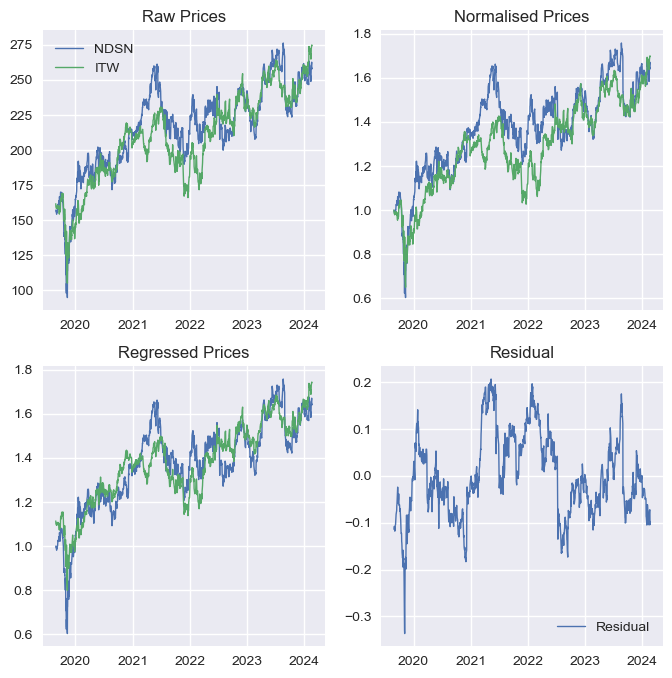



Cointegrated Augmented Dickey-Fuller test 


Regressand          Regressor  t-statistic Significance Level  \
0  ΔResidual  (Lag 1, Residual)    -3.342836                 1%   
1  ΔResidual  (Lag 1, Residual)    -3.342836                 5%   
2  ΔResidual  (Lag 1, Residual)    -3.342836                10%   

   Critical Value  Is Stationary  
0       -3.905337          False  
1       -3.341086           True  
2       -3.047889           True



Error Correction Model fitting 


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0      ΔNDSN                ΔITW     0.835860        0.026776    31.216194   
1      ΔNDSN  (Lag 1, Residuals)    -0.019452        0.005604    -3.471024   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000536               True



Error Correction Model reverse fitting 


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0       ΔITW               ΔNDSN     0.528123        0.016918    31.216194   
1       ΔITW  (Lag 1, Residuals)     0.013444        0.004460     3.014535   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.002626               True



Fit to Ornstein-Uhlenbeck Stochastic Differential Equation 
Theta: 5.0446

Half-life in years: 0.1374 years
Half-life in working days: 34.6258 days

Equilibrium level μ_e: 0.0007542482712599772
Equilibirum level μ_e can be compared to the AR(1) fitting intercept: 1.4948596913815732e-05

Sum Squared Errors: 0.3698969099466535

Annualised Variance: 0.0014678448807406883
Diffusion in Ornstein-Uhlenbeck SDE (sigma_ou): 0.6142890207962778
Diffusion in equilibrium to dictate entry trade signals (sigma_eq): 0.19339471629269073

Diffusion of sample residuals (note the difference): 0.017306405403000324


Grid search optimisation results for Z 
Maximum return occurs with Z=0.5


Z  Total Trades  Total Return
0   0.30            13      1.342951
1   0.35            12      1.569872
2   0.40            12      1.750467
3   0.45            11      1.635998
4   0.50            11      1.990894
5   0.55             9      1.613324
6   0.60             8      1.553289
7   0.65             7      1.453029
8   0.70             7      1.505446
9   0.75             6      1.201023
10  0.80             6      1.368125
11  0.85             6      1.422050
12  0.90             5      1.201392
13  0.95             4      1.071924
14  1.00             3      0.782388
15  1.05             2      0.506784
16  1.10             1      0.312006
17  1.15             1      0.312006
18  1.20             1      0.528211
19  1.25             1      0.528211
20  1.30             1      0.528211
21  1.35             1      0.528211
22  1.40             1      0.528211



Backtest plots for optimal Z


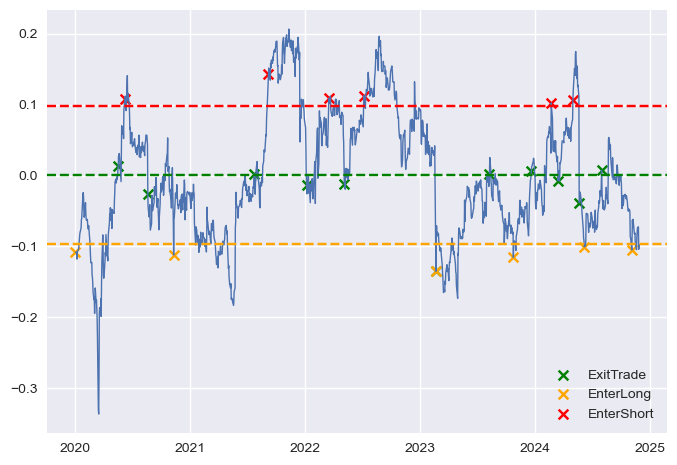

In [14]:
""" Notebook Reference 3.0 """

# Create Bivariate Engle Granger class 
EG_2 = BivariateEngleGranger()

# Initialise first pair based on economic reasoning for cointegration to exist (Visa on Mastercard)
ticker_2_a = "NDSN"
ticker_2_b = "ITW"
start_date_2 = "2020-01-01"
end_date_2 = "2024-11-29"

EG_2.initialise_single_procedure(ticker_2_a, ticker_2_b, start_date_2, end_date_2, benchmark=benchmark)

EG_2.run_single_procedure(include_strategy_backtest=False)

We comment on the full procedure at each step for NDSN on ITW.

Naively regressing NSDN on ITW results in $\beta_C = 0.900522$, post normalisation. Under a 5% significance level hypothesis testing setup, we see that p-values for both ITW and the constant are under 5% hence both coefficients are statistically significant i.e. do not equal 0.

It is interesting to note that the raw prices timeseries plots shows the timeseries sitting closely on top of one another. Whilst we still normalise the timeseries, this observation tells us that the raw prices are on similar scales. It is harder visually to tell if the residual is stationary in this example than the first pair.

The resulting residual from the regression is then tested for stationarity. The residual is stationary at the 5% and 10% level, but we fail to reject the null hypothesis of a unit root at the 1% level. We can still proceed, however, as stationarity at 5% significance is confirmed. 

We then fit the Error Correction Model both the correct way round and with *wrong way* residuals. The long run equilibrium correction term is significant in both instances. 

At this point, we should carry out the procedure for ITW on NDSN i.e. the other way round. This is included in *Appendix A* below. We actually see that the residual this way round does not yield a stationary spread even at 10% significance level. Accordingly, we continue with NDSN on ITW.

We then fit to the OU SDE. We observe a half-life of 35 days which is moderately longer than our first example. Our $\sigma_{eq}$ is also more volatile than our first example.

Searching for the Z yielding maximum total return results in Z=0.5, which has 11 trades. The number of trades is significantly less than Mastercard vs Visa. 

Now we consider our final pair - CSX on UNP. The results for the full procedure are below, sourced from *[Notebook Reference 4.0]*.

Price regression summary 


Regressand Regressor  Coefficient  Standard Error  t-statistic  \
0        CSX  Constant     0.057725        0.012142     4.754237   
1        CSX       UNP     1.012661        0.009663   104.796734   

   p-value (t-dist)  
0          0.000002  
1          0.000000



Timeseries plots


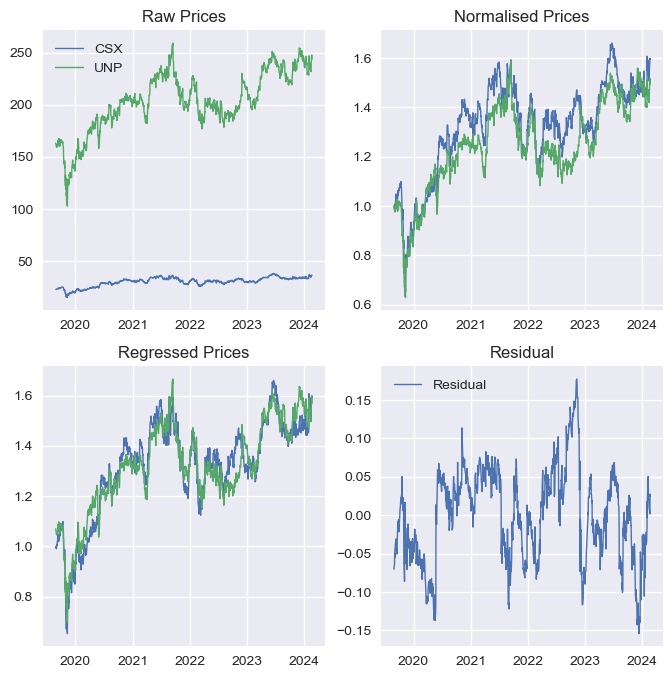



Cointegrated Augmented Dickey-Fuller test 


Regressand          Regressor  t-statistic Significance Level  \
0  ΔResidual  (Lag 1, Residual)    -4.031211                 1%   
1  ΔResidual  (Lag 1, Residual)    -4.031211                 5%   
2  ΔResidual  (Lag 1, Residual)    -4.031211                10%   

   Critical Value  Is Stationary  
0       -3.905337           True  
1       -3.341086           True  
2       -3.047889           True



Error Correction Model fitting 


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0       ΔCSX                ΔUNP     0.844746        0.020291    41.631767   
1       ΔCSX  (Lag 1, Residuals)    -0.026577        0.006557    -4.053133   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000054               True



Error Correction Model reverse fitting 


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0       ΔUNP                ΔCSX     0.691708        0.016615    41.631767   
1       ΔUNP  (Lag 1, Residuals)     0.023972        0.005934     4.039801   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000057               True



Fit to Ornstein-Uhlenbeck Stochastic Differential Equation 
Theta: 7.3730

Half-life in years: 0.0940 years
Half-life in working days: 23.6908 days

Equilibrium level μ_e: 0.0026604621593522898
Equilibirum level μ_e can be compared to the AR(1) fitting intercept: 7.67123580406054e-05

Sum Squared Errors: 0.24804921062943602

Annualised Variance: 0.000984322264402524
Diffusion in Ornstein-Uhlenbeck SDE (sigma_ou): 0.5053488241656862
Diffusion in equilibrium to dictate entry trade signals (sigma_eq): 0.13159911109980413

Diffusion of sample residuals (note the difference): 0.014172140391017203


Grid search optimisation results for Z 
Maximum return occurs with Z=0.35


Z  Total Trades  Total Return
0   0.30            23      2.372540
1   0.35            23      2.602423
2   0.40            18      2.063857
3   0.45            17      2.044830
4   0.50            16      2.137935
5   0.55            14      2.067119
6   0.60            12      1.897631
7   0.65            10      1.503727
8   0.70             8      1.073951
9   0.75             8      1.143796
10  0.80             6      0.864476
11  0.85             5      0.721139
12  0.90             5      0.771629
13  0.95             3      0.468718
14  1.00             3      0.482162
15  1.05             3      0.496930
16  1.10             2      0.315182
17  1.15             2      0.330487
18  1.20             1      0.193382
19  1.25             1      0.202391
20  1.30             1      0.202391
21  1.35             0      0.000000
22  1.40             0      0.000000



Backtest plots for optimal Z


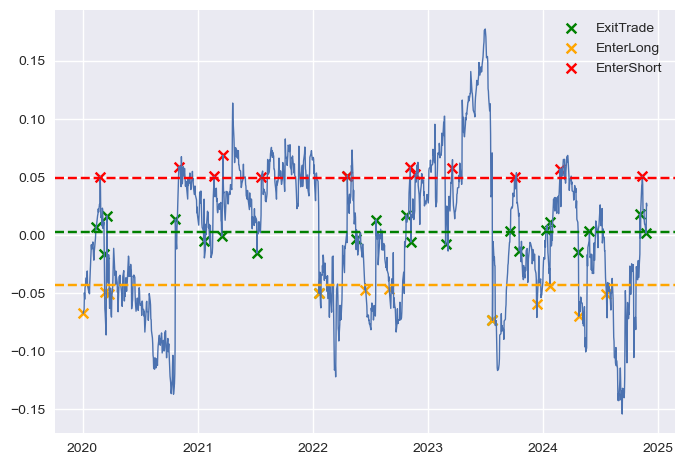

In [15]:
""" Notebook Reference 4.0 """

# Create Bivariate Engle Granger class 
EG_3 = BivariateEngleGranger()

# Initialise first pair based on economic reasoning for cointegration to exist (Visa on Mastercard)
ticker_3_a = "CSX"
ticker_3_b = "UNP"
start_date_3 = "2020-01-01"
end_date_3 = "2024-11-29"

EG_3.initialise_single_procedure(ticker_3_a, ticker_3_b, start_date_3, end_date_3, benchmark=benchmark)

EG_3.run_single_procedure(include_strategy_backtest=False)

Naively regressing CSX on UNP results in $\beta_C = 1.012661$, post normalisation. Again, both the constant and UNP are statistically significant.

The plots show that the raw prices are on materially different scales. Normalisation and regression brings both timeseries very much in line with one another. On a visual level, the spread looks more stationary than our NDSN vs ITW example. 

The CADF stationarity test results in the null hypothesis being rejected at the 1% level. It has a test statistic slightly less strong than our Mastercard vs Visa example. *Appendix B* contains this procedure the other way round i.e. UNP on CSX. Observe that the CADF test statistic is stronger for CSV on UNP rather than vice versa (-4.031209 vs -3.95817). We therefore proceed with CSX on UNP.

The Error Correction Models are then fitted. Both fittings result in a statistically significant long run equilibrium mean reversion.

Fitting the spread to the OU SDE results in a half-life similar to the Mastercard vs Visa scenario. Volatility is slightly higher when comparing $\sigma_{eq}$.

The Z optimisation results in Z=0.35, resulting in 23 trades over the 5 year period. 

### Structural Breaks

Structural breaks are when the cointegrating relationship breaks down. This could entail the cointegrating relationship fully ending, or it could also entail the hedging ratio between the equity pairs changing. Overall, it means that the long-term equilibrium previously shared no longer holds.

Given that the three pairs are all equity pairs in the same industry, one of the reasons why a structural break may occur is if one of the pairs encounters an event. This event could be both positive or negative, but it has to impact the perceived value for the company. Examples include a breakthrough in R&D, news of potential M&A or a restructuring of the company. This is a non-exhaustive list of events that would significantly impact the price of one company and resultantly lead to a structural break as the cointegrating relationship would change, or break down entirely.

Structural breaks can also be the result of an industry wide shock, rather than on a firm level. Regulation could become tighter meaning that there is less differentiation within the market meaning that the cointegrating relationship becomes tighter, and therefore the old equilibrium no longer holds. Commodity price shocks could suddenly change key input prices leading to a shake-up sectors' cost of raw materials. This could impact the cointegrating relationship as one firm may be impacted more by these external shocks.

Overall, the impact of a structural break is that is that the cointegrating relationship will have to be re-estimated. In the case of the cointegrating relationship breaking down, then the mean reverting spread is no more and the trade must be exited, as there is no statistical arbitrage underpinning the trade.


&nbsp;


## Part II - Backtesting

In this section we focus on backtesting the pairs trading strategy designed in *Part I*. We cover the returns calculation, produce various plots (rolling beta with respect to S&P500 excess returns, rolling sharpe ratio, drawdown etc.) and use ML inspired backtesting of train/test splits.

We begin with describing in detail the calculation of cumulative PnL / total return. This is the calculation used in the grid search for optimal Z. The returns for the strategy are calculated in *evaluate_backtest_for_z()* which is called inside *optimise_trading_strategy()* in *[Notebook Reference 1.10]*. The table below is the second output from *evaluate_backtest_for_z()* and is sourced from *[Notebook Reference 4.1]*. The strategy table can also be sourced via the instance attribute *optimal_strategy*.

The methodology for determining cumulative PnL is to calculate the daily arithmetic return for both stocks. For each day $i$, we put each stock's daily return into a row vector given by:

$$ Returns_i = \begin{bmatrix} Return_A & Return_B \end{bmatrix} = \begin{bmatrix} Return_{MA} & Return_V \end{bmatrix} $$

We then take the dot product of $Returns_i$ and $B_{Coint}$ and multiply by $Indicator$ to get the portfolio daily return.

$$ 
Indicator_i =
\begin{cases} 
1, & \text{if Long in period }i \\
-1, & \text{if Short in period }i \\
0, & \text{if Inactive in period }i
\end{cases}
$$

$$ PortfolioReturn_i = Returns_i \cdot B_{Coint} \times Indicator_i = 
\begin{bmatrix} Return_A & Return_B \end{bmatrix} \cdot \begin{bmatrix} 1 \\ -\beta_C \end{bmatrix} \times Indicator_i $$

This gives us our daily portfolio return. To obtain our cumulative return, we take a cumulative product of $1+PortfolioReturn_i$ and then subtract 1. The final period entry for this column is our cumulative PnL or total return. An extract of these running calculations is detailed in the table below.

In [16]:
""" Notebook Reference 4.1 """

# Trading data timeseries
df_formatted = df_trades.copy()
df_formatted.index = df_formatted.index.date

df_formatted.tail().T

# also can be accessed via EG_reverse.optimal_strategy

2024-11-21 2024-11-22 2024-11-25 2024-11-26 2024-11-27
Residual           -0.040337  -0.020938  -0.021804  -0.006917  -0.011596
EqResidual         -0.000104  -0.000104  -0.000104  -0.000104  -0.000104
UpperBound          0.025837   0.025837   0.025837   0.025837   0.025837
LowerBound         -0.026045  -0.026045  -0.026045  -0.026045  -0.026045
UpperBreach            False      False      False      False      False
LowerBreach             True      False      False      False      False
Position                Long       Long       Long       Long       Long
Position_t-1            Long       Long       Long       Long       Long
IsPositionChanged      False      False      False      False      False
EnterShort             False      False      False      False      False
EnterLong              False      False      False      False      False
ExitTrade              False      False      False      False      False
MA                   1.74596   1.765484    1.78494   1.791313   1.804532
V                    1.67979   1.679899   1.697623   1.690198   1.705808
MA_returns          0.004995   0.011182    0.01102    0.00357    0.00738
V_returns           0.008165   0.000065   0.010551  -0.004374   0.009236
MA_cum_returns       0.74596   0.765484    0.78494   0.791313   0.804532
V_cum_returns        0.67979   0.679899   0.697623   0.690198   0.705808
Benchmark           1.825962   1.832294   1.837829   1.848345   1.841319
BenchmarkReturn      0.00534   0.003468    0.00302   0.005722  -0.003801
PortfolioReturn    -0.004367   0.011108  -0.001077   0.008585   -0.00321
CumReturn           1.472471   1.499936   1.497243   1.518683   1.510599
CumTrades                 27         27         27         27         27

We describe each field in the table:
- *Residual*: current residual for the period
- *EqResidual*: equilibrium level for residual from OU SDE fitting, given by $\mu_e$
- *UpperBound*: upper trading entry signal, given by $\mu_e + Z \sigma_{eq}$
- *LowerBound*: lower trading entry signal, given by $\mu_e - Z \sigma_{eq}$
- *UpperBreach*: residual breaches the upper bound
- *LowerBreach*: residual breaches the upper bound
- *Position*: position at end of day, given by Inactive/Long/Short
- *Position_t-1*: position at end of previous day, given by Inactive/Long/Short
- *IsPositionChanged*: change in position on that day if True
- *EnterShort*: short position is entered into on that day
- *EnterLong*: long position is entered into on that day
- *ExitTrade*: position is exited on that day
- *MA*: normalised prices for Ticker A
- *V*: normalised prices for Ticker B
- *MA_returns*: arithmetic returns for Ticker A
- *V_returns*: arithmetic returns for Ticker B
- *MA_cum_returns*: cumulative arithmetic returns for Ticker A
- *V_cum_returns*: cumulative arithmetic returns for Ticker B
- *Benchmark*: normalised price for S&P500 index
- *BenchmarkReturn*: arithmetic daily returns for S&P500 benchmark
- *PortfolioReturn*: portfolio return on that day
- *CumReturn*: cumulative portfolio return to date
- *CumTrades*: cumulative number of trades to date

### Plots

Continuing with our Mastercard vs Visa example, we now produce various plots to backtest our strategy. We begin with plotting the rolling beta of the trading strategy vs S&P500 excess returns. We self-implement this, rather than using *pyfolio reloaded* - the method is aptly named *plot_sp500_xs_rets_rolling_beta()* and found below in *[Notebook Reference 5.0]*.

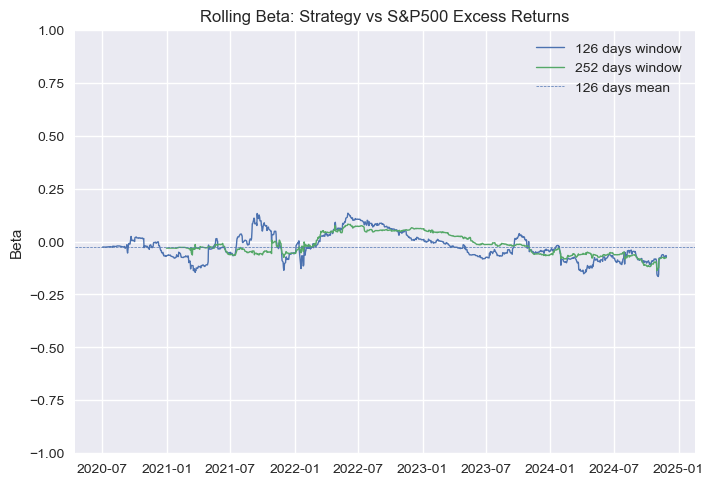

In [17]:
""" Notebook Reference 5.0 """

# Plot rolling beta with respect to S&P500 excess returns
EG_reverse.plot_sp500_xs_rets_rolling_beta(df_trades)

To calculate the rolling beta, we require a timeseries for S&P500 excess returns. The risk adjusted returns are not directly available on Yahoo Finance so we use the 3 month T-bill rate as a proxy for risk free - this comes under ticker *^IRX* on yfinance. This rate is extracted from yfinance and then transformed into a daily rate, assuming that there are 252 trading days in a year. Now that we have our daily risk free rate, we calculate S&P500 excess returns by taking the difference between S&P500 arithmetic daily returns and the daily risk free rate.

We then take windows of 126 and 252 days (i.e. half a year and an entire year) and compute the rolling beta. Beta is defined as:

$$ \beta_x = \frac{\text{Cov}(r_x, r_m)}{\text{Var}(r_m)} $$

where:
- $\beta_x$ is the market beta of strategy $x$
- $r_x$ are strategy $x$ returns in the relevant window
- $r_m$ is the market returns in the relevant window

In our exercise, $r_m$ is the S&P500 excess returns. 

Now onto the actual plot, we observe that our rolling beta is close to zero, namely it is bounded between -0.2 and 0.2. This suggests that the trading strategy has a low sensitivity/correlation to market excess returns. In a finance context, the trading strategy is relatively market-neutral meaning that its performance does not depends on whether the market falls or rises. This also means the strategy has reduced systematic risk. With a low beta, the strategy has returns driven primarily by alpha.

The half year window rolling beta has a marginally negative mean. A negative beta would mean that strategy returns are inversely related to S&P500 excess returns. However, the mean is so close to zero it is more appropriate to deduce that strategy returns are uncorrelated with S&P500 excess returns.

We now use *pyfolio-reloaded* to generate various plots, found in *[Notebook Reference 5.1]*. The benchmark passed into the *pyfolio* plots is S&P500 returns, and not excess returns.

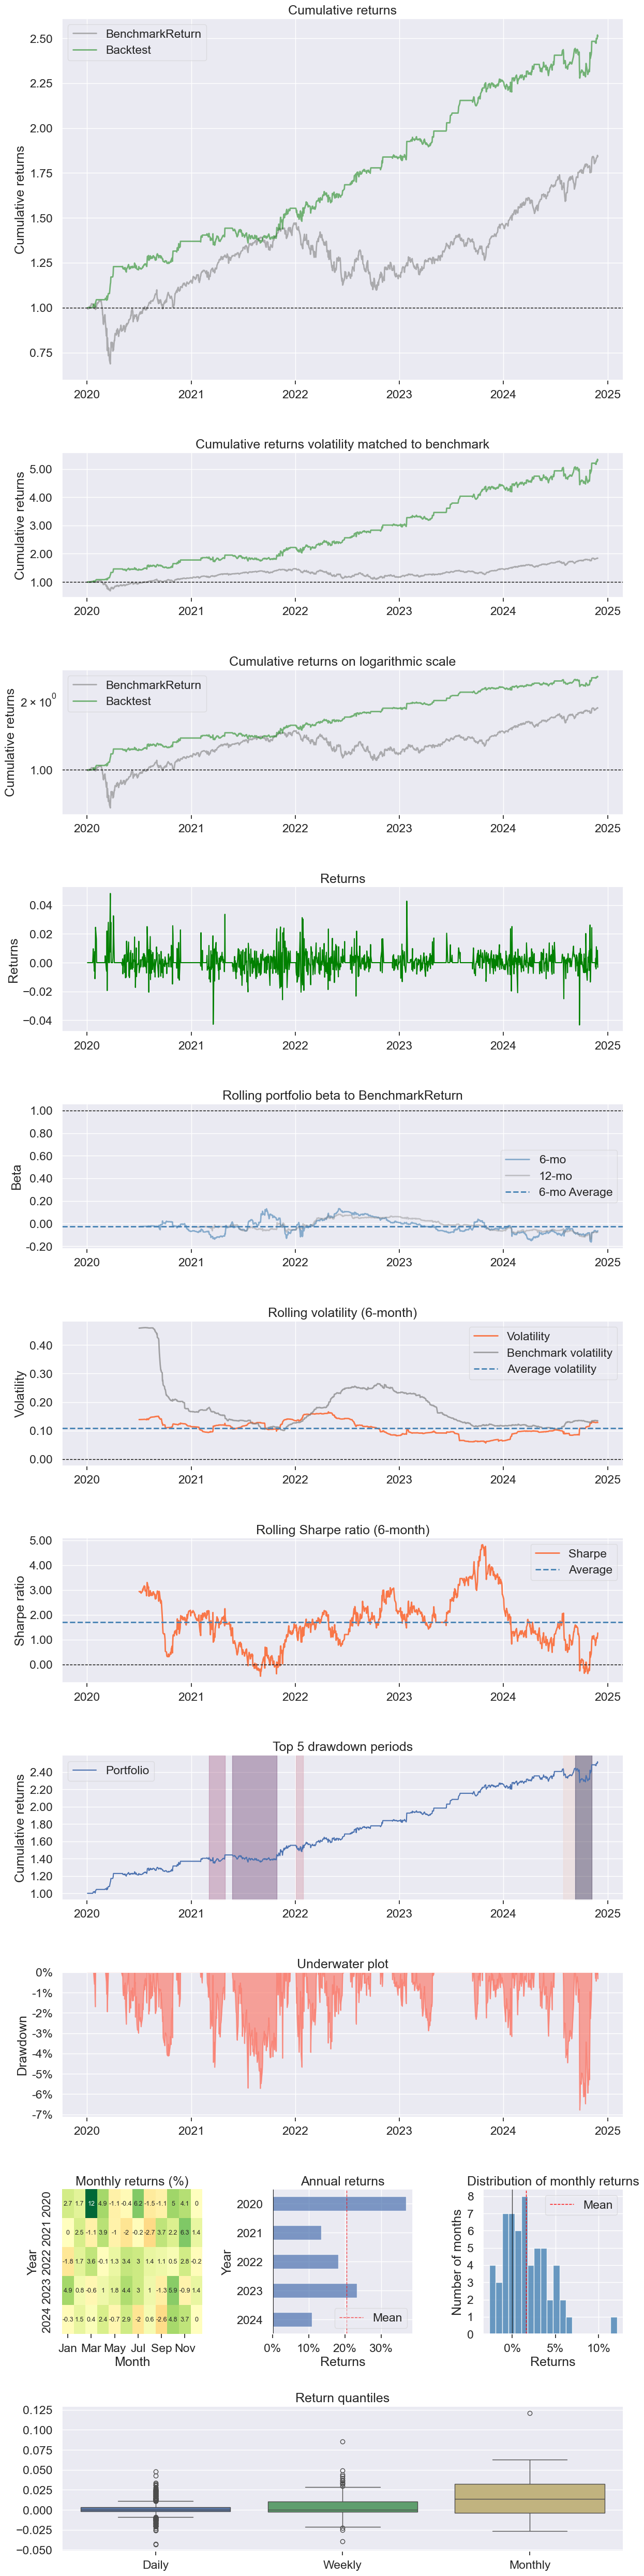

In [18]:
""" Notebook Reference 5.1 """

# Create tearsheet from pyfolio
EG_reverse.create_pyfolio_returns_tear_sheet(df_trades)

The first table provides summary statistics of the trading strategy. Our cointegrated strategy of Mastercard on Visa has an annualised return of 20.7%. This is artificially high - one reason for this is that we have look-ahead bias. The main source of look-ahead bias stems from the naive regression of prices. This allowed us to artificially optimise our residual as it was using information not available at the start of the trading strategy. Later in the report, we reduce this bias via a train/test split. 



We now analyse the plots.

*Cumulative returns* \
The plot shows that the cumulative return of the cointegrated trading strategy is effectively above the benchmark S&P500 across the entire trading period. There is an initial divergence at the beginning, driven entirely by covid, after which the cumulative returns converge around the second half of 2021. The inflationary pressures beginning in 2022 did not phase the trading strategy and we see another divergence in the cumulative returns. Overall, we see that the trading strategy is not affected too much on the downside, as there is a general upward trend for the cumulative trading strategy returns.

It is also useful to consider the final snapshot of the strategy at the end of 2024. We consider the normalised price series which start from 1 in 2020. The cointegrated strategy grows from 1 to 2.51 (derived from CumReturn+1). This is notably more growth than the S&P500 benchmark, which grows from 1 to 1.84. We can clearly see this in the cumulative returns plot. Importantly, the cointegrated trading strategy has higher total return than just a naked long position in either underlying of Mastercard (1.80) or Visa (1.71). 

*Cumulative returns volatility matched to benchmark* \
This plot shows cumulative returns normalised to have the same volatility as the S&P500 benchmark over the same period. This plot gives a sense of risk adjusted returns by comparing them on an identical level of volatility/risk. It is clear to see that the cointegrated risk adjusted returns lie above the benchmark returns over the entire period. 

*Returns* \
This plot shows the daily arithmetic returns of the portfolio. It is also useful to see the periods of inactivity i.e. when there was no live spread position. These periods of inactivity make the strategy returns look less like white noise.

*Rolling portfolio beta to BenchmarkReturn* \
This is a similar plot to the self-implemented rolling beta aforementioned however there is one key difference - the *pyfolio* plot uses S&P500 returns as a benchmark whereas the self-implemented version benchmarks against S&P500 excess returns. Overall, this nuance does not have a material impact and we can clearly see that the shape of the two plots is effectively identical.

*Rolling volatility (6-month)* \
The 6 month rolling volatility is relatively stable. It fluctuates between ~5% at the low end and ~15% at the high end. In comparison to the S&P500 benchmark, the rolling volatility of the cointegrated strategy is effectively lower at every period, apart from the end 2021 period and end 2024 period. It is interesting to note the difference in volatility in the covid period. The cointegrated trading strategy shows low volatility in the aftermath of the March 2020 covid stress, whilst the S&P500 benchmark sees a vol of nearly 50%.

*Rolling Sharpe ratio (6-month)* \
We observe risk-adjusted returns via the Sharpe ratio of 1.7, which is particularly strong. However, *pyfolio* uses the S&P500 daily returns as its benchmark / assumed risk-free rate. Therefore the cointegrated strategy's Sharpe ratio is even more impressive as clearly the S&P500 returns will be higher than the risk free rate, hence the effective hurdle rate for the strategy's Sharpe ratio is higher. 

In 2021 and late 2024, the Sharpe ratio falls below 1, indicating periods where the portfolio's risk-adjusted returns were weaker than the S&P500. This ties up with the convergence of the cumulative returns in 2021. There are brief periods, particularly in 2021, where the Sharpe ratio drops below 0. This implies that the portfolio underperformed the S&P500 during those times.

*Top 5 drawdown periods* \
This plot visually represents the second table on drawdown periods. A drawdown is defined as the amount lost from the observed peak. We observe that the worst drawdown is only 6.8%, experienced in 2024 Q4. Notice that the second worst drawdown has the longest recovery period so despite a smaller percentage decline than the worst drawdown, the recovery period was more prolonged, indicating slower portfolio recovery / mean reversion. Drawdowns appear clustered in certain periods (i.e. 2021 and 2024), suggesting these were periods of heightened market volatility or portfolio-specific risks.

*Underwater plot* \
The plot shows the drawdowns of the strategy from its peak values over time. It ties up with the drawdown table described above the plots. We see that the deepest drawdown occurs around late 2024. The portfolio experiences drawdowns frequently, with multiple shallow to moderate drawdowns (up to ~3% or ~4%) throughout the period. This suggests regular periods of underperformance relative to the portfolio's previous peaks.

*Remaining plots* \
The remaining plots breakdown the distribution of returns. We see the strongest portfolio return by far in March 2020 during the peak of the Covid shock. This contributes to the 2020 annual returns being the richest out of all the years, by quite soem margin.

It is possible that we see elevated returns in October / November of each year. It could be interesting to test the statistical significance of this assertion.

Looking at the histogram distribution of monthly returns, we deduce that returns *nearly* follow a bell-shaped distribution. The monthly returns are slightly skewed upwards, but it is clear that it is unimodal.

### Look-Ahead Bias

The largest caveat with all this analysis is that we have look-ahead bias. An example of this is during the regression of raw prices to obtain $B_{Coint}$ - we use the entire financial time series to generate $\beta_C$. Clearly, we would not have known the realisation of the price time series at the outset of the trading strategy. 

One solution to this would be to use a rolling window calculation for our hedging ratio. We would take a window of say, 6 months, and regress our prices to obtain our $\beta_C$. This hedging ratio would change day on day, but we would not want to rebalance our hedge daily. One pragmatic approach is to define some bounds for which we will allow our $\beta_C$ to drift within. Whilst our $\beta_C$ remains within the bounds, we retain our initial hedge ratio. However, if $\beta_C$ breaches the bounds, we rebalance our hedge to the new $\beta_C$ and define new tolerance bounds accordingly. This method is a good pragmatic approach to obtaining an adaptive beta, as well as avoiding look-ahead bias for our backtests. 

Another solution to avoid look-ahead bias is to use Kalman filters for adaptive estimation. These allow us to dynamically estimate the relationship between our asset pairs in real time whilst markets evolve. The advantage to using this is that it effectively filters out noise in observations, hence improving the stability of trading signals. In volatile and unpredictable markets, the Kalman filter performs better at capturing shifts in relationships, in comparison to a rolling window.

We now consider the regular re-estimation of cointegrated relationships i.e. 5-8 months rolling window shifting by 10-15 days. There will be advantages and disadvantages to implementing such an adaptive beta. 

The first advantage is that it is unrealistic to assume that financial time series are static, therefore having an adaptive beta allows the strategy to adapt to evolving market conditions. Market conditions change frequently due to economic shifts, regulatory changes or external shocks. If we assume a fixed $\beta_C$ for an extended period, this may lead to suboptimal trading signals if the relationship drifts over time. Furthermore, regular re-estimation reduces the risk of structural breaks invalidating the strategy.

On the other hand, there are also disadvantages when it comes to an adaptive beta. For example, frequent re-estimation can introduce noise and reduce signal stability. It also may increase transaction costs if the strategy adjusts positions too often. 

The recommendation of using a 5-8 month rolling window with re-estimation every 10-15 days is a good proposal to strike a balance between adapting to new data and avoiding excessive noise/slippage. If the market is relatively stable, a rolling window approach should suffice. Otherwise, we may have to employ Kalman filters.

The final section covered in this report is to use train / test splits - this will also help mitigate look-ahead bias. 

### Train / Test Splits

Taking inspiration from the machine learning world, we split our trading time series into a training dataset and test dataset. The test dataset will then not suffer from look-ahead bias. 

We "train" our trading strategy on the training dataset set. Namely, we use the training dataset for the following purposes:
1. Fit the naive regression of prices to obtain $\beta_C$.
2. Test the resulting residual for stationarity. This resulting residual spans across the training dataset only.
3. Verify the statistical significance of the long run equilibrium in the Error Correction Models. This test spans across the training dataset only.
4. Fit the training set residual to the OU SDE to obtain parameters $\mu_e$ and $\sigma_{eq}$.
5. Vary Z to find optimal value that maximises total return within the training period.

Once the model has been fitted using the training dataset, we invoke the test dataset and hence the strategy becomes *live*. The parameter for the *live* date is passed into *BivariateEngleGranger.initialise_single_procedure()* as *live_start_date*.

We would expect the training dataset to perform better than the test dataset.

It is standard in the machine learning world to set the train/test split as 80/20. There are also other methods such as cross validation which partitions the entire dataset into n groups, leaves out one of the groups for training, and then tests on said group. We must be careful with our example as we are training on financial time series, which is clearly ordered in time, and we must preserve this property. There are two main options when it comes to time series cross validation: sliding window cross validation, or expanding window cross validation. We shall just choose the standard 80/20 split to determine the start of our *live* strategy. 

The outputs below split our Mastercard on Visa example into 80/20 train/test. It is sourced from *[Notebook Reference 6.0]*.

Price regression summary (training dataset)


Regressand Regressor  Coefficient  Standard Error  t-statistic  \
0         MA  Constant    -0.072170        0.011835    -6.097876   
1         MA         V     1.085424        0.010402   104.349092   

   p-value (t-dist)  
0      1.540561e-09  
1      0.000000e+00



Timeseries plots


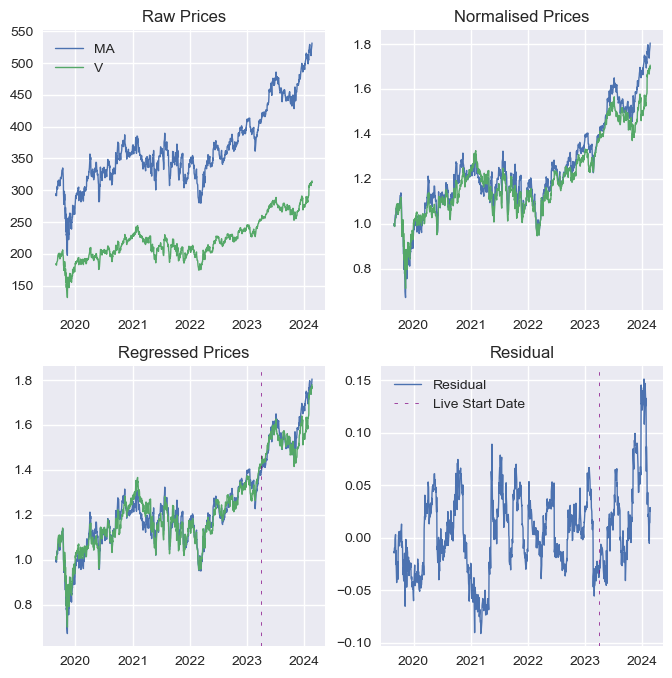



Cointegrated Augmented Dickey-Fuller test (training dataset)


Regressand          Regressor  t-statistic Significance Level  \
0  ΔResidual  (Lag 1, Residual)    -3.942315                 1%   
1  ΔResidual  (Lag 1, Residual)    -3.942315                 5%   
2  ΔResidual  (Lag 1, Residual)    -3.942315                10%   

   Critical Value  Is Stationary  
0       -3.907571           True  
1       -3.342328           True  
2       -3.048750           True



Error Correction Model fitting (training dataset)


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0        ΔMA                  ΔV     1.031159        0.015153    68.049747   
1        ΔMA  (Lag 1, Residuals)    -0.035081        0.008379    -4.186571   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000031               True



Error Correction Model reverse fitting (training dataset)


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0         ΔV                 ΔMA     0.799541        0.011749    68.049747   
1         ΔV  (Lag 1, Residuals)     0.028426        0.007389     3.847295   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000127               True



Fit to Ornstein-Uhlenbeck Stochastic Differential Equation (training dataset)
Theta: 9.0294

Half-life in years: 0.0768 years
Half-life in working days: 19.3449 days

Equilibrium level μ_e: -0.0006494084434906883
Equilibirum level μ_e can be compared to the AR(1) fitting intercept: -2.2857073048156392e-05

Sum Squared Errors: 0.0866866725404513

Annualised Variance: 0.0003439947323033782
Diffusion in Ornstein-Uhlenbeck SDE (sigma_ou): 0.2997162754999002
Diffusion in equilibrium to dictate entry trade signals (sigma_eq): 0.07052856061133313

Diffusion of sample residuals (note the difference): 0.009366939046760149


Grid search optimisation results for Z (training dataset)
Maximum return as at 2023-12-06 occurs with Z=0.5


Z  Total Trades  Total Return
0   0.30            22      0.871377
1   0.35            20      0.855440
2   0.40            18      0.871242
3   0.45            15      0.737327
4   0.50            15      0.878738
5   0.55            13      0.755204
6   0.60            11      0.647695
7   0.65            11      0.793047
8   0.70            10      0.778063
9   0.75            10      0.794878
10  0.80             8      0.623814
11  0.85             8      0.651471
12  0.90             7      0.622867
13  0.95             6      0.496464
14  1.00             5      0.441254
15  1.05             4      0.356344
16  1.10             3      0.262346
17  1.15             2      0.182007
18  1.20             2      0.182007
19  1.25             2      0.182007
20  1.30             0      0.000000
21  1.35             0      0.000000
22  1.40             0      0.000000



Backtest plots for optimal Z


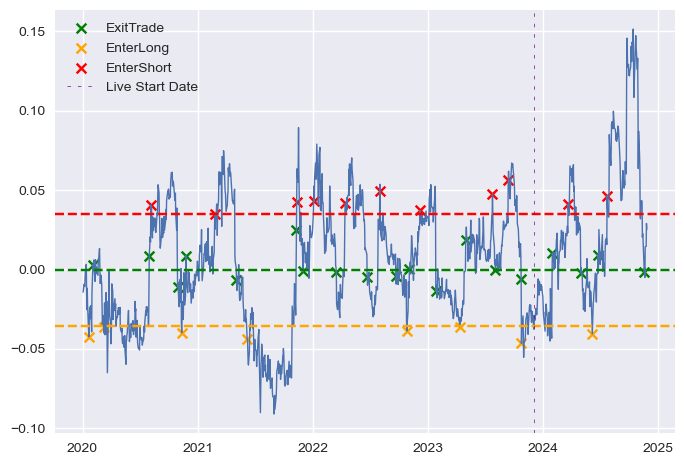



Rolling beta with respect to S&P500 excess returns


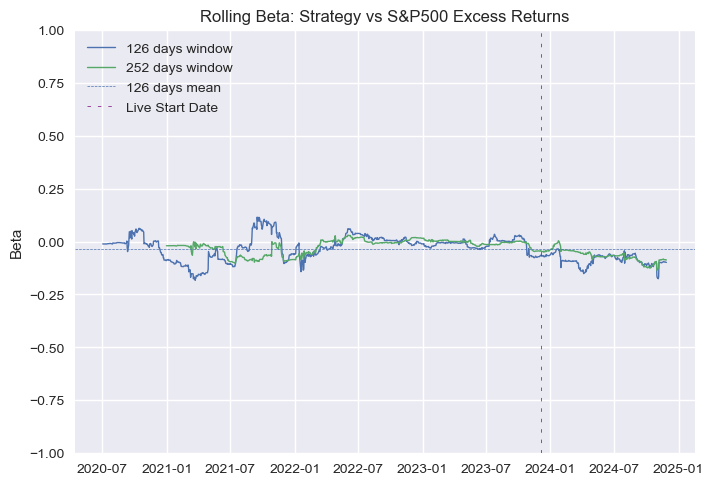



Tearsheet generation


In-sample  Out-of-sample       All
MA cumulative returns          0.396632       0.304790  0.822311
V cumulative returns           0.378871       0.247023  0.719484
Benchmark cumulative returns   0.406353       0.318596  0.854411

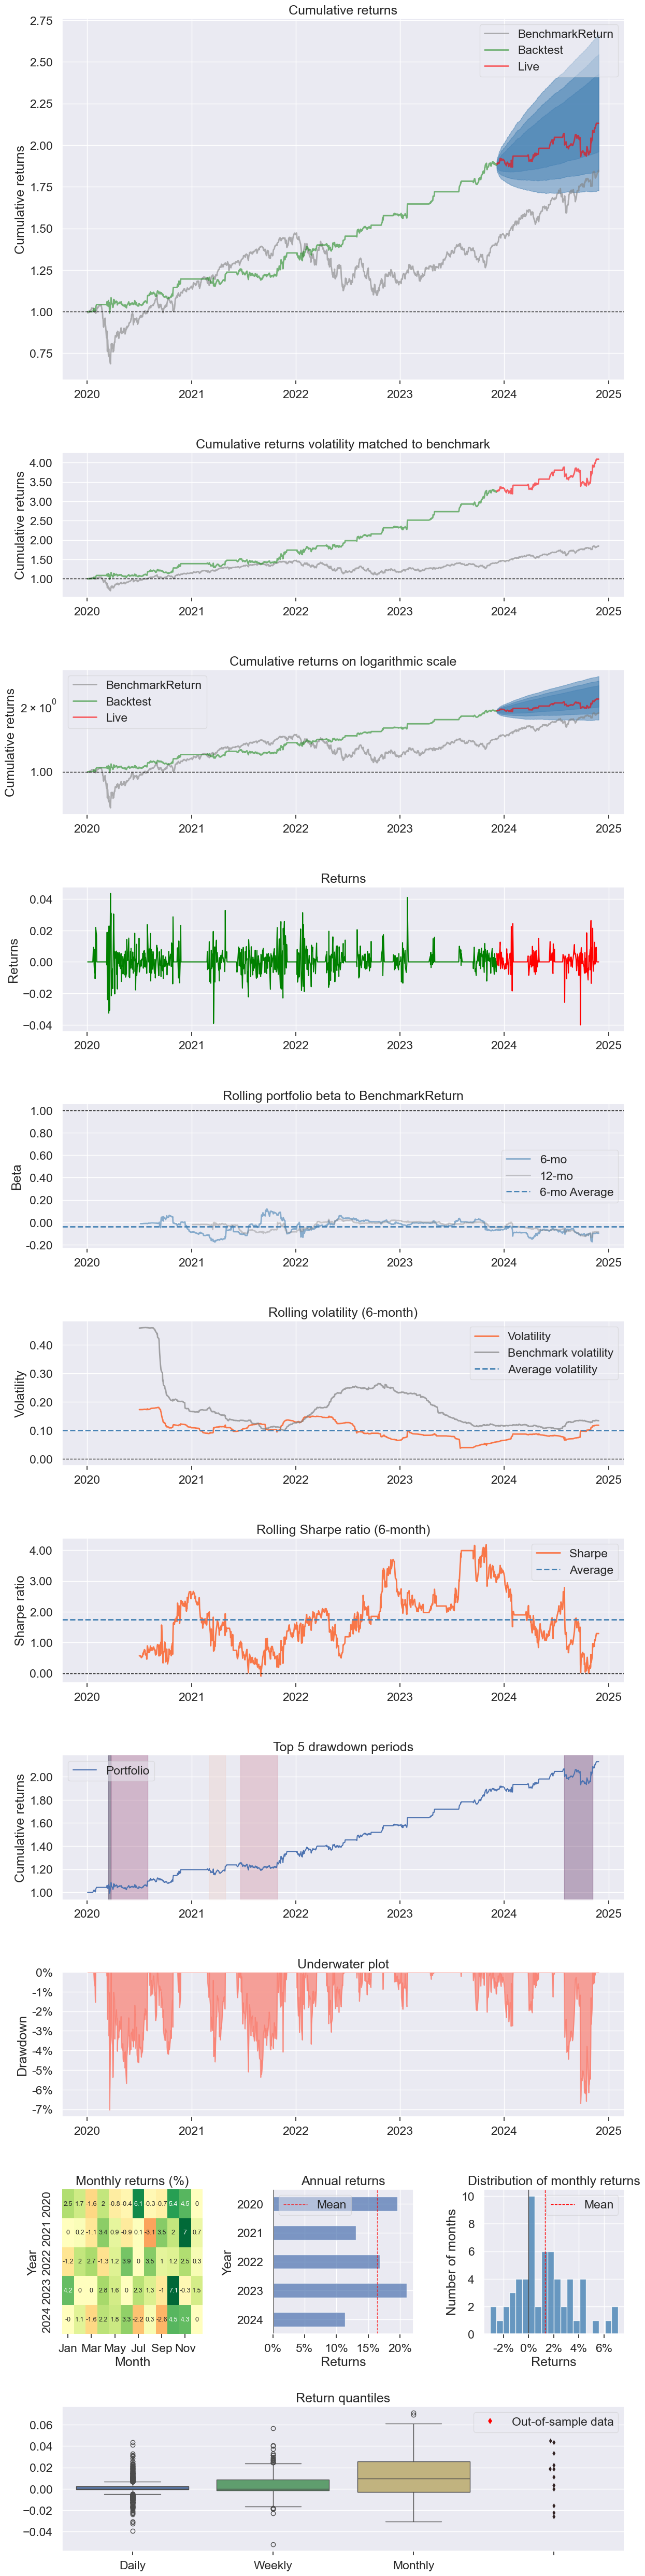

In [19]:
""" Notebook Reference 6.0 """

training_pct = 0.8
iso_format = "%Y-%m-%d"
dt_start = dt.datetime.strptime(start_date, iso_format)
dt_end = dt.datetime.strptime(end_date, iso_format)
dt_live = (dt_start + (dt_end - dt_start) * training_pct).date()
dt_live = dt.datetime.strftime(dt_live, iso_format)

EG_reverse_live = BivariateEngleGranger()

EG_reverse_live.initialise_single_procedure(ticker_b, ticker_a, start_date, end_date, benchmark=benchmark,
                                            live_start_date=dt_live)

EG_reverse_live.run_single_procedure()

Given that our training dataset is different, we would expect all parameters to differ from the earlier analysis. Indeed, we see a change in the hedging ratio $\beta_C$. 

An overlay has been added to relevant plots in order to indicate the start of the *live* strategy i.e. the end of training and beginning of testing. We can already see the residual plot behave with higher volatility during the test period. We also see a different value chosen for Z=0.5.

Moving onto the tearsheet generation, there is an extra table at the top depicting the in-sample, out-of-sample and all period cumulative returns. The cumulative returns are given for Mastercard, Visa and the benchmark S&P500. This table is useful to compare against the corresponding values for the cointegrated trading strategy.

*In-sample cumulative returns comparison* \
All of Mastercard, Visa and the S&P500 returned ~40% during the in-sample / training period. Over the same period, the cointegrated strategy returned 88%. There is a significant out-performance from the cointegrated strategy, however we must remember that we have look-ahead bias in the training period. 

*Out-of-sample cumulative returns comparison* \
Over the testing period. Visa returned 25%, and Mastercard and the S&P500 returned ~31%. Now, the cointegrated strategy returned only 13% over the same period. This is a significant reversal in the performance of the strategy! The under-performance of the cointegrated strategy is significant in the context of the underlying stocks and the benchmark. In this example, it appears that look-ahead bias greatly impacted performance. This makes intuitive sense because look-ahead bias would have allowed us to secure the most optimal residual profile.

*Sharpe ratio* \
The most interesting plot to look at in the test/train split procedure is the rolling Sharpe chart. It is noted that the rolling Sharpe begins a downward trend as soon as the *live* trading strategy begins in December 2023 - this is as expected, but we are most concerned with the drop-off being as small as possible. On a positive note, we see that the test period Sharpe ratio is 1.31. This is still a good level for risk-adjusted returns.

Given the under-performance of the cointegrated strategy over the testing period, it would be required to develop this strategy more robustly before employing it in practice. Implementing Kalman filters for an adaptive beta would be the first port-of-call. This would allow the strategy to adapt to different market regimes rather than maintaining a static hedge ratio. 

This now concludes our analysis for the Mastercard on Visa pairs trading strategy.

### Remaining cointegrated strategies

We now move onto the final section of this report - the backtesting of our remaining pairs NDSN on ITW, and CSX on UNP.

Again, we use train/test splits. The following backtesting results are for NDSN on ITW and are found in *[Notebook Reference 6.1]*.

Price regression summary (training dataset)


Regressand Regressor  Coefficient  Standard Error  t-statistic  \
0       NDSN  Constant     0.169576        0.018372     9.230148   
1       NDSN       ITW     0.939180        0.014429    65.088954   

   p-value (t-dist)  
0               0.0  
1               0.0



Timeseries plots


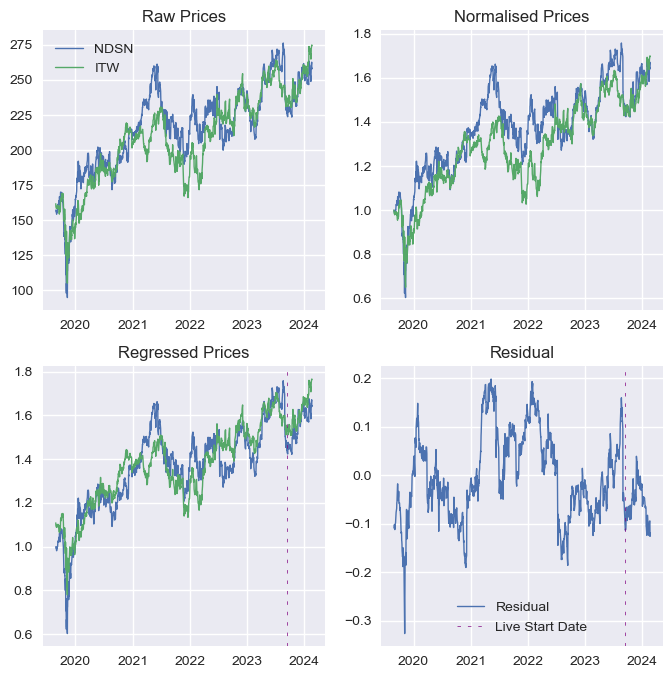



Cointegrated Augmented Dickey-Fuller test (training dataset)


Regressand          Regressor  t-statistic Significance Level  \
0  ΔResidual  (Lag 1, Residual)    -3.188228                 1%   
1  ΔResidual  (Lag 1, Residual)    -3.188228                 5%   
2  ΔResidual  (Lag 1, Residual)    -3.188228                10%   

   Critical Value  Is Stationary  
0       -3.906343          False  
1       -3.341645          False  
2       -3.048277           True



Error Correction Model fitting (training dataset)


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0      ΔNDSN                ΔITW     0.830482        0.028640    28.996919   
1      ΔNDSN  (Lag 1, Residuals)    -0.019179        0.005887    -3.257980   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.001156               True



Error Correction Model reverse fitting (training dataset)


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0       ΔITW               ΔNDSN     0.519519        0.017916    28.996919   
1       ΔITW  (Lag 1, Residuals)     0.014226        0.004659     3.053614   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.002315               True



Fit to Ornstein-Uhlenbeck Stochastic Differential Equation (training dataset)
Theta: 5.0897

Half-life in years: 0.1362 years
Half-life in working days: 34.3192 days

Equilibrium level μ_e: 0.0017432637559084572
Equilibirum level μ_e can be compared to the AR(1) fitting intercept: 3.4855621263070994e-05

Sum Squared Errors: 0.35113967511065003

Annualised Variance: 0.001393411409169246
Diffusion in Ornstein-Uhlenbeck SDE (sigma_ou): 0.5985644555383359
Diffusion in equilibrium to dictate entry trade signals (sigma_eq): 0.18760811292626808

Diffusion of sample residuals (note the difference): 0.01778600713058539


Grid search optimisation results for Z (training dataset)
Maximum return as at 2024-06-03 occurs with Z=0.4


Z  Total Trades  Total Return
0   0.30            14      1.372023
1   0.35            13      1.471467
2   0.40            13      1.761000
3   0.45            10      1.429119
4   0.50            10      1.587000
5   0.55            10      1.627071
6   0.60             9      1.513181
7   0.65             9      1.734536
8   0.70             7      1.298595
9   0.75             7      1.407399
10  0.80             6      1.118311
11  0.85             5      0.954932
12  0.90             5      0.987972
13  0.95             5      1.143827
14  1.00             4      0.859952
15  1.05             1      0.287491
16  1.10             1      0.287491
17  1.15             1      0.287491
18  1.20             1      0.496541
19  1.25             1      0.496541
20  1.30             1      0.496541
21  1.35             1      0.496541
22  1.40             1      0.496541



Backtest plots for optimal Z


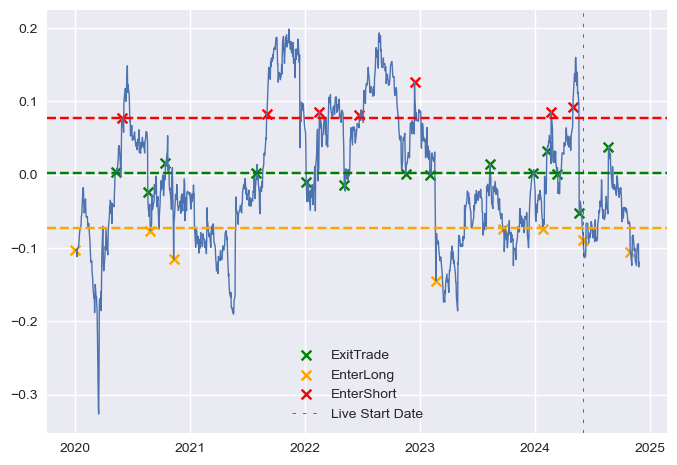



Rolling beta with respect to S&P500 excess returns


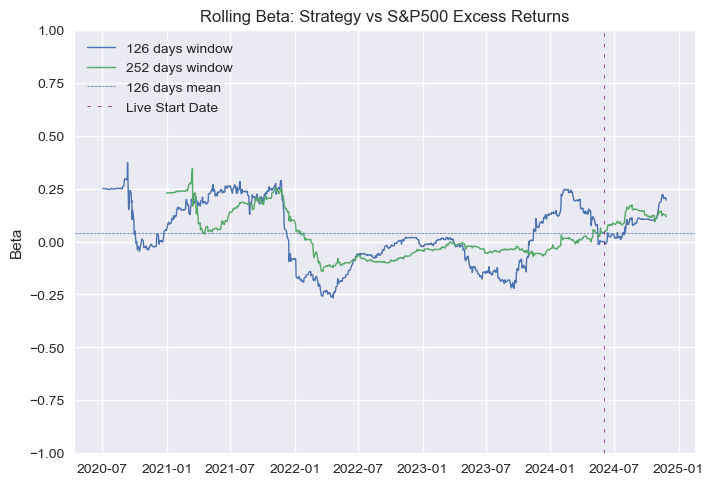



Tearsheet generation


In-sample  Out-of-sample       All
NDSN cumulative returns        0.459989       0.134140  0.655832
ITW cumulative returns         0.478444       0.164233  0.721253
Benchmark cumulative returns   0.633275       0.135394  0.854411

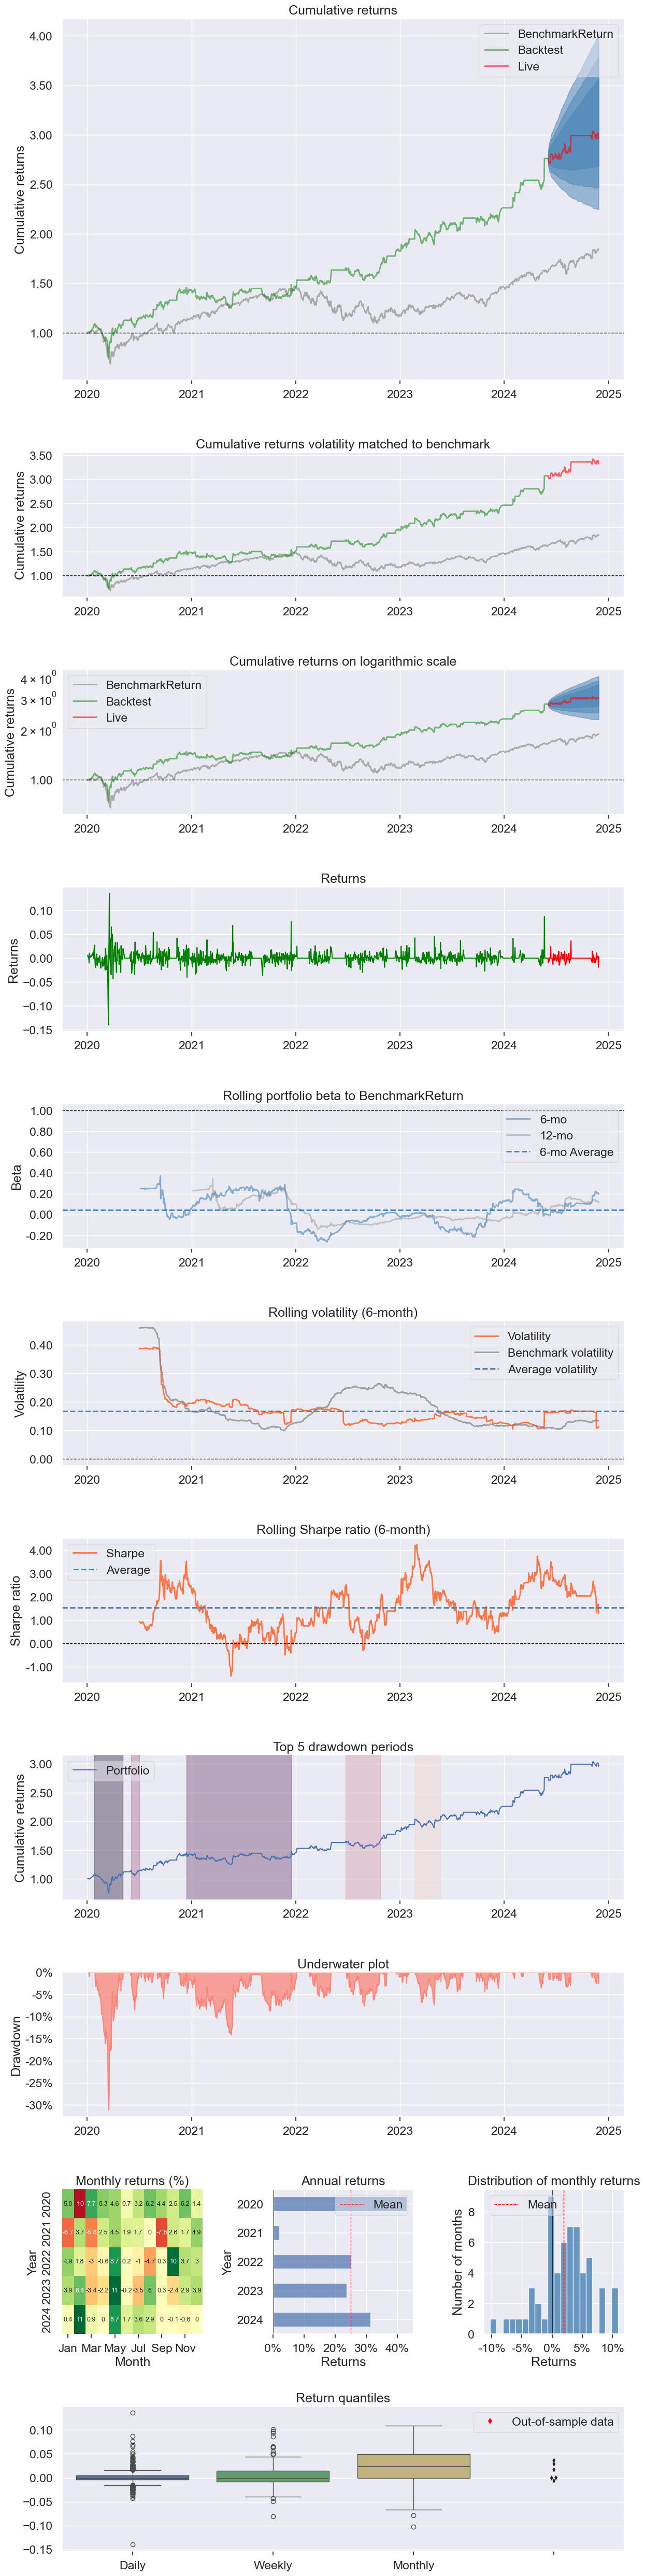

In [20]:
""" Notebook Reference 6.1 """

training_pct_2 = 0.9

dt_start_2 = dt.datetime.strptime(start_date_2, iso_format)
dt_end_2 = dt.datetime.strptime(end_date_2, iso_format)
dt_live_2 = (dt_start_2 + (dt_end_2 - dt_start_2) * training_pct_2).date()
dt_live_2 = dt_live_2 + dt.timedelta(1)  # ensure weekday
dt_live_2 = dt.datetime.strftime(dt_live_2, iso_format)

EG_2_live = BivariateEngleGranger()

EG_2_live.initialise_single_procedure(ticker_2_a, ticker_2_b, start_date_2, end_date_2, benchmark=benchmark,
                                            live_start_date=dt_live_2)

EG_2_live.run_single_procedure()

For this pair, we have split the train/test partition into 90/10, resulting in 5 months of testing data. This is because upon testing with a split of 80/20, the resulting residual over the training period was not stationary, even at 10% significance. Increasing the training period resulted in a stationary residual, but only at 10% significance. It must be said that having only 5 months of training data is sub-optimal, as there may not be sufficient time for significant mean reversion to occur.

*Rolling beta* \
Across the entire period, we see that the NDSN on ITW cointegrated trade is only moderately correlated with S&P500 excess returns. The rolling beta can be seen ranging between 0.3 at the high end and -0.25 at the low end. It is interesting to note that it has positive and negative correlation with the market.

*Cumulative returns* \
The cumulative returns plot shows the cointegrated strategy performing extremely strongly during the training period. We can quantify this by looking at the tables for cumulative returns. We see the cointegrated strategy obtaining 176% return whereas over the same period the benchmark obtained 63% return. The underlying stocks obtained 40-45% return. Clearly there is great out-performance during the training period. However, once we move to the testing dataset, the cointegrated strategy severely under-performed and only returned 8%. This is in comparison to 13-16% for the benchmark and underlying pairs. Again, we see that the statistical arbitrage strategy does not generalise well and this implies some overfitting with respect to the training data. 

One interesting trend to note is that the cointegrated strategy appears to have good downside protection. This behaviour is similarly exhibited in our MA vs V example.

*Rolling Sharpe ratio (6-month)* \
From the table we see that the training data Sharpe ratio average as 1.26, whilst the test data Sharpe ratio average 1.37. The test period Sharpe ratio must be taken with a pinch of salt, however, as it is a rolling window Sharpe that takes into account a lucrative trade at the end of the training period. The sudden upward spike in cumulative portfolio returns at the end of the training period is positively influencing most of the test period Sharpe ratio, as the test period lasts only 5 months. 

*Drawdown periods* \
The test period experiences little drawdown. This is partly because the majority of its test period is spent without an active position, coupled with the fact that the strategy enters the test period at its peak. During the training period, we see the cointegrated strategy take heavy unrealised losses during Covid. The underwater plot tells us that at the worst point, the strategy was down 30%. It is unrealistic that the active position would have been kept open and in reality, risk management would have stopped out the position. 

We now finally tackle the final pair -  CSX on UNP. The backtest outputs are below and are sourced from *[Notebook Reference 6.2]*.

Price regression summary (training dataset)


Regressand Regressor  Coefficient  Standard Error  t-statistic  \
0        CSX  Constant    -0.017441        0.014391    -1.211933   
1        CSX       UNP     1.080624        0.011969    90.289003   

   p-value (t-dist)  
0          0.225828  
1          0.000000



Timeseries plots


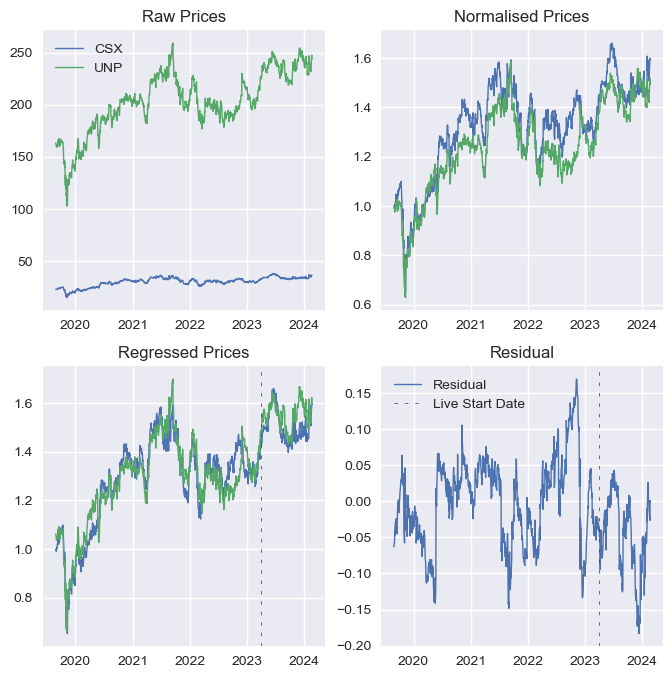



Cointegrated Augmented Dickey-Fuller test (training dataset)


Regressand          Regressor  t-statistic Significance Level  \
0  ΔResidual  (Lag 1, Residual)    -3.646533                 1%   
1  ΔResidual  (Lag 1, Residual)    -3.646533                 5%   
2  ΔResidual  (Lag 1, Residual)    -3.646533                10%   

   Critical Value  Is Stationary  
0       -3.907571          False  
1       -3.342328           True  
2       -3.048750           True



Error Correction Model fitting (training dataset)


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0       ΔCSX                ΔUNP     0.851009        0.022113    38.484865   
1       ΔCSX  (Lag 1, Residuals)    -0.026118        0.007402    -3.528598   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000437               True



Error Correction Model reverse fitting (training dataset)


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0       ΔUNP                ΔCSX     0.705443        0.018330    38.484865   
1       ΔUNP  (Lag 1, Residuals)     0.026339        0.006729     3.913992   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000097               True



Fit to Ornstein-Uhlenbeck Stochastic Differential Equation (training dataset)
Theta: 7.8486

Half-life in years: 0.0883 years
Half-life in working days: 22.2553 days

Equilibrium level μ_e: 0.0007818921461400767
Equilibirum level μ_e can be compared to the AR(1) fitting intercept: 2.3976958973331322e-05

Sum Squared Errors: 0.20726576807651878

Annualised Variance: 0.0008224832066528522
Diffusion in Ornstein-Uhlenbeck SDE (sigma_ou): 0.4623722967268997
Diffusion in equilibrium to dictate entry trade signals (sigma_eq): 0.11670249166630367

Diffusion of sample residuals (note the difference): 0.014483893332572944


Grid search optimisation results for Z (training dataset)
Maximum return as at 2023-12-06 occurs with Z=0.35


Z  Total Trades  Total Return
0   0.30            20      2.130859
1   0.35            20      2.445538
2   0.40            17      2.163964
3   0.45            15      1.958459
4   0.50            13      1.758140
5   0.55            10      1.249243
6   0.60             9      1.186347
7   0.65             8      0.968104
8   0.70             8      1.004119
9   0.75             8      1.086028
10  0.80             6      0.826932
11  0.85             6      0.883038
12  0.90             4      0.588863
13  0.95             4      0.603808
14  1.00             4      0.629232
15  1.05             4      0.666910
16  1.10             4      0.698949
17  1.15             4      0.715593
18  1.20             3      0.542044
19  1.25             2      0.352981
20  1.30             1      0.205846
21  1.35             1      0.205889
22  1.40             1      0.214327



Backtest plots for optimal Z


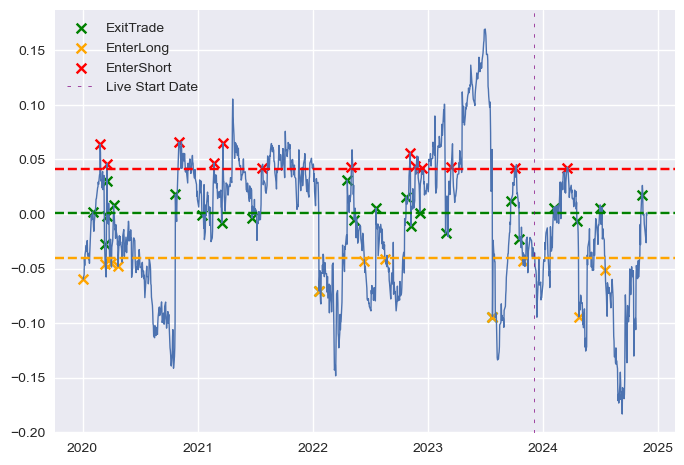



Rolling beta with respect to S&P500 excess returns


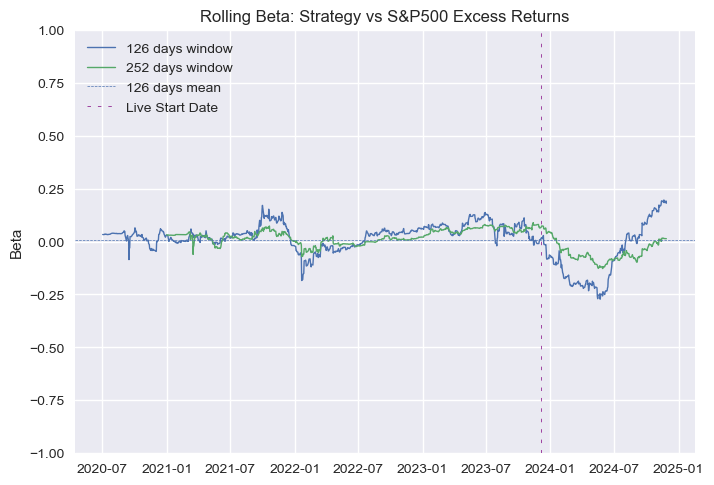



Tearsheet generation


In-sample  Out-of-sample       All
CSX cumulative returns         0.451784       0.102607  0.600748
UNP cumulative returns         0.397277       0.075754  0.503126
Benchmark cumulative returns   0.406353       0.318596  0.854411

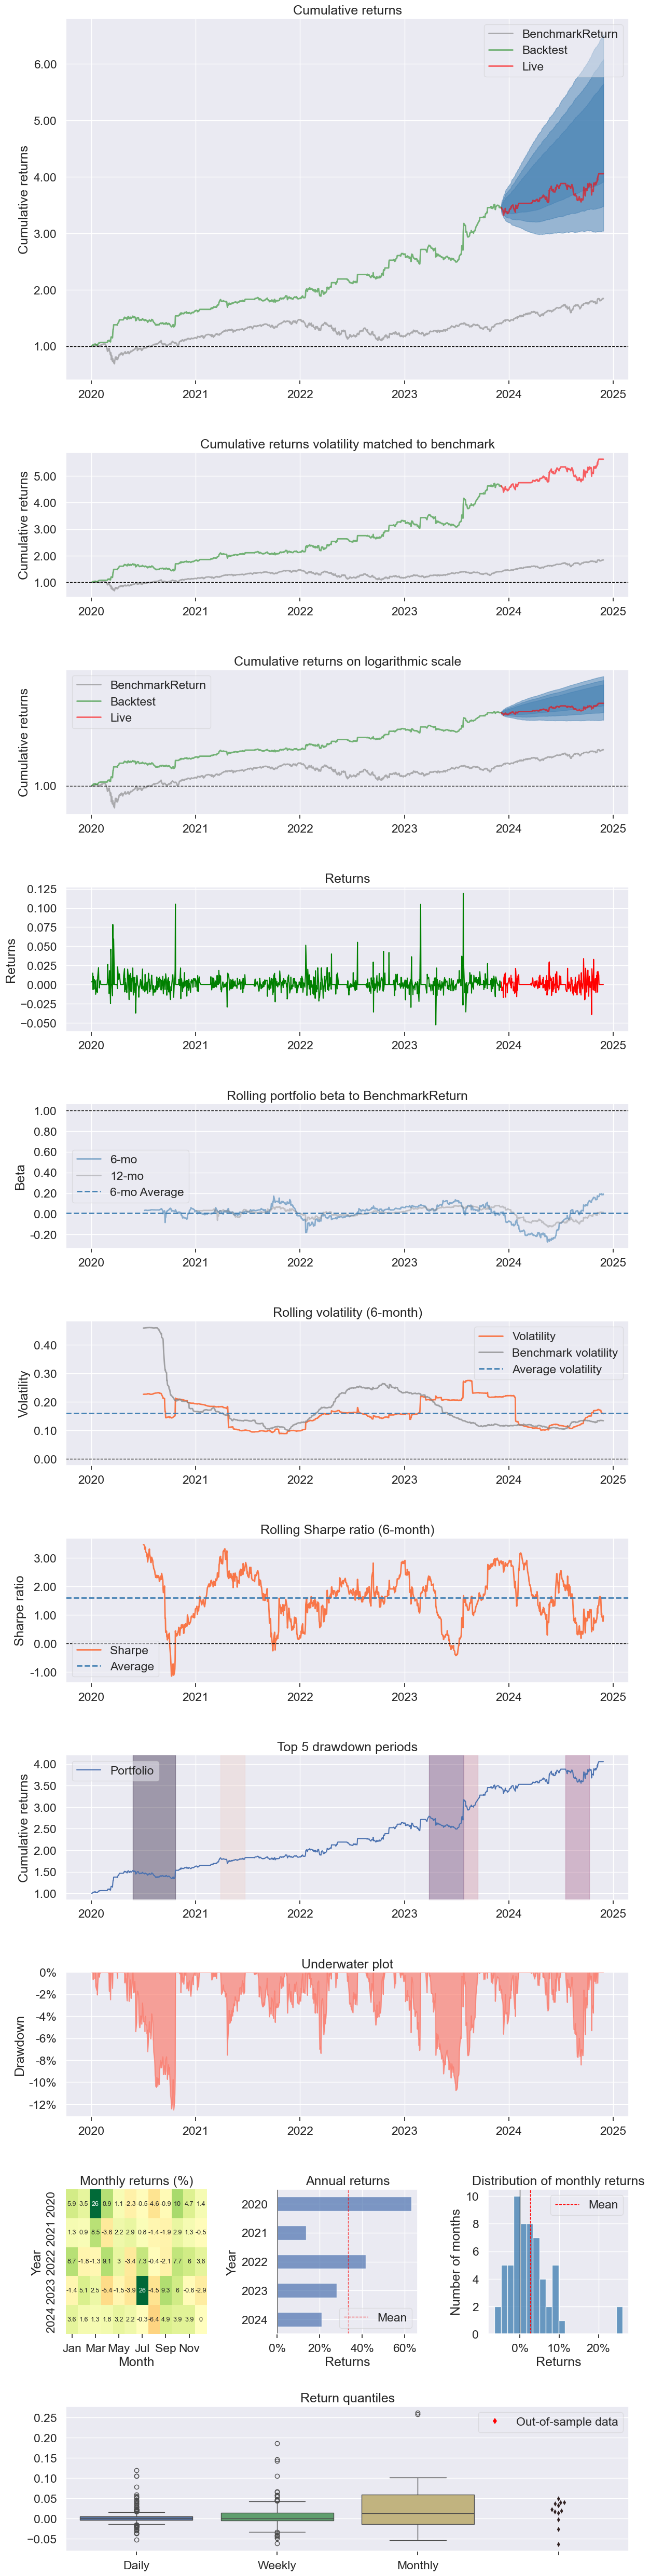

In [21]:
""" Notebook Reference 6.2 """

training_pct_3 = 0.8

dt_start_3 = dt.datetime.strptime(start_date_3, iso_format)
dt_end_3 = dt.datetime.strptime(end_date_3, iso_format)
dt_live_3 = (dt_start_3 + (dt_end_3 - dt_start_3) * training_pct_3).date()
dt_live_3 = dt.datetime.strftime(dt_live_3, iso_format)

EG_live_3 = BivariateEngleGranger()

EG_live_3.initialise_single_procedure(ticker_3_a, ticker_3_b, start_date_3, end_date_3, benchmark=benchmark,
                                            live_start_date=dt_live_3)

EG_live_3.run_single_procedure()

Following the introduction of a training/test split, we observe that the hedging ration remains relatively similar. Namely the hedge ratio updates from 1.01 to 1.08. This means that the resulting residual is also relatively similar.

The test for stationarity in the residual returns different results, however. When the model is trained on the first 80% of the period, we see that the resulting residual is not stationary at the 1% significance level. It is still stationary at the 5% and 10% significance level, hence we can still proceed. We can quantify the loss in strength of stationarity via the increase in t-statistic in the CADF test.

We also confirm that the Error Correction Models have significant long run equilibrium mean reversion. This is true for both the standard ECM and for the ECM with "wrong way" residuals.

New values for our trading parameters are obtained. Namely, we have an updated $\mu_e$, $\sigma_{eq}$ and Z. The new Z is optimised to be 0.35, so again we have tight bounds for entry signals.

*In-sample returns and Sharpe* \
The cumulative returns plot shows the cointegrated trading strategy far above the benchmark S&P500. To quantify this, we look at the cumulative return table values during the training period. The cointegrated trading strategy returned a vast 245% over the training period. The associated underlying stocks and benchmark returned 40%-45% over the same period. 

We also observe a Sharpe ratio of 1.86 for the cointegrated strategy over the training period. There is a clear out-performance for the in-sample data. Our assertion is that this is due to look-ahead bias.

*Out-of-sample returns and Sharpe* \
The cointegrated trading strategy returned 18% across the testing period. This is actually higher than the returns of the underlying stocks CSX and UNP, which returned 10% and 8% respectively across the same period. This implies that the cointegrated trading strategy outperformed its underlying pairs, and generated alpha in the market. However, the benchmark returned 32% across the testing period, meaning that there was still under-performance relative to the market. 

We also see a Sharpe ratio of 1.25, which is above 1, for the cointegrated strategy across the testing period. This Sharpe ratio is relatively good on an absolute basis. On the other hand, we do observe a significant drop in Sharpe ratio across the training and testing periods, from 1.86 to 1.25.

*Rolling beta* \
The rolling beta plot is interesting because we see a visual increase in the strength of correlation with the market once the testing period is entered. The absolute level of beta is still low, however, as it fluctuates between -0.2 and 0.2.

*Drawdown periods* \
The drawdown periods are more contained than our NDSN vs ITW example. The maximum drawdown across the entire 2020-24 period is 12%. The largest drawdown within the testing period is 8%, however we have to bear in mind the 1 year tenor of the testing period.


&nbsp;


## Final Thoughts

This now concludes the pairs trade design and backtesting of our three cointegrated trading strategies.

Taking all three strategies into consideration, we see that all strategies' out-of-sample Sharpe ratios were above 1. All test period Sharpe ratios hovered around 1.3. This is a decent outcome for risk-adjusted returns.

Without taking risk into account, we see that the first two pairs (MA vs V and NDSN on ITW) return a cumulative return that is less rich than the benchmark or their underlying stocks. Only the final pair of CSX on UNP performed better than its underlying stocks, and even then it did not beat the benchmark.

All strategies chose a very low Z figure to determine the trading entry signals. This means that the number of trades would have been on the higher end. In reality, higher churn would incur higher slippage (transaction costs) and this would therefore erode into the profit of the strategy.

To further improve the trading strategy, we could implement Kalman filters, as touched on earlier in the report. This would allow for an adaptive hedging ratio which would adjust to evolving market regimes.


&nbsp;


## Method Implementation

Guided by the project brief, we now include a brief section on the methods implemented/adjusted.

1. *Multivariate Linear Regression* \
   i. Self-implemented \
   ii. Located in module multivariate_linear_regression.py; class MultivariateLinearRegression; method fit() \
   iii. Computes the OLS estimator $\hat{\beta} = (X^TX)^{-1}X^TY$

2. *Vector Auto-Regressive Model* \
   i. Self-implemented \
   ii. Located in module vector_autoregressive_model.py; class VectorAutoregressiveModel; method fit() \
   iii. Creates a lagged matrix for the autoregressive model and regresses to find optimal coefficients

3. *Database Creation and Web Scraping* \
    i. Used *pandas* and *sqlalchemy* \
    ii. Located in module timeseries_data.py; class TimeseriesData; methods create_sp500_database() and  scrape_sp500_constituents() \
    iii. Scrapes wiki page for S&P500 tickers and then calls yfinance for the pricing timeseries of each ticker and stores in database

4. *Cointegrated Augmented Dickey-Fuller Test* \
    i. Self-implemented \
    ii. Located in module augmented_dickey_fuller.py; class ADF; method stationarity_test() \
    iii. Tests for stationarity of a given series \
    iv. Implements MacKinnon's 2010 approximation to the Dickey-Fuller distribution
    
5. *Error Correction Model* \
    i. Self-implemented \
    ii. Located in module bivariate_engle_granger.py; class BivariateEngleGranger; method check_error_correction_model_mean_reversion() \
    iii. Implements the Error Correction Model including the argument to override the regression using "wrong way" residuals

6. *Ornstein-Uhlenbeck Stochastic Differential Equation Fitting* \
    i. Self-implemented \
    ii. Located in module bivariate_engle_granger.py; class BivariateEngleGranger; method fit_to_ornstein_uhlenbeck_sde() \
    iii. Fits a mean reverting residual to the OU SDE
    
7. *Grid-Search Optimisation for Z* \
    i. Self-implemented \
    ii. Located in module bivariate_engle_granger.py; class BivariateEngleGranger; method optimise_trading_strategy() \
    iii. Finds Z that maximises total return
    
8. *Returns Tear Sheet* \
    i. Used *pyfolio-reloaded* \
    ii. Located in module bivariate_engle_granger.py; class BivariateEngleGranger; method create_pyfolio_returns_tear_sheet() \
    iii. Displays various plots used to evaluate trading strategy

9. *Solve System of Equations* \
    i. Used *numpy.linalg.solve* \
    ii. Located in module multivariate_linear_regression.py; class MultivariateLinearRegression; method fit() \
    iii. More computationally efficient that finding the matrix inverse

10. *Information Criterion (AIC, BIC)* \
    i. Self-implemented \
    ii. Located in module vector_autoregressive_model.py; class VectorAutoRegressiveModel; method get_optimal_lag() \
    iii. Computes AIC and BIC for VAR fitting and informs user of optimal lag given maximum lags


&nbsp;


## Appendix A

Full procedure for ITW on NDSN sourced from *[Notebook Reference A]*:

Price regression summary 


Regressand Regressor  Coefficient  Standard Error  t-statistic  \
0        ITW  Constant     0.059630        0.017362     3.434490   
1        ITW      NDSN     0.894337        0.012516    71.458008   

   p-value (t-dist)  
0          0.000613  
1          0.000000



Timeseries plots


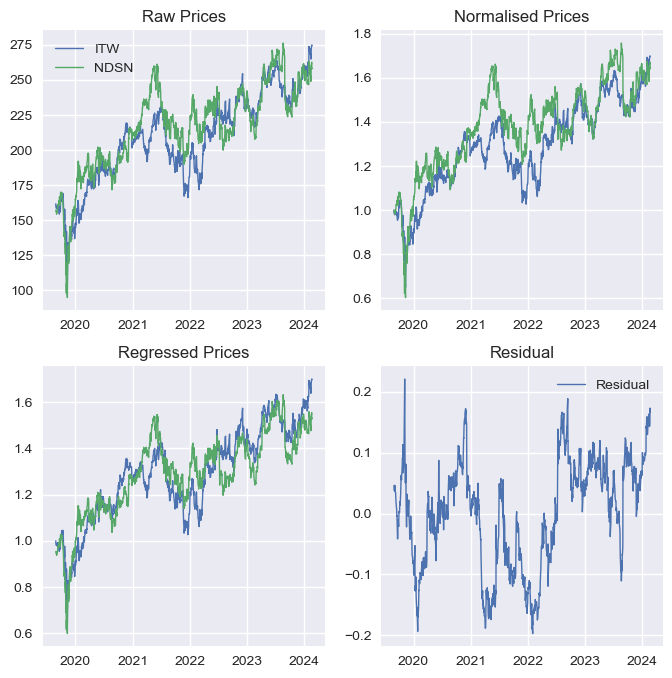



Cointegrated Augmented Dickey-Fuller test 


Regressand          Regressor  t-statistic Significance Level  \
0  ΔResidual  (Lag 1, Residual)    -2.871236                 1%   
1  ΔResidual  (Lag 1, Residual)    -2.871236                 5%   
2  ΔResidual  (Lag 1, Residual)    -2.871236                10%   

   Critical Value  Is Stationary  
0       -3.905337          False  
1       -3.341086          False  
2       -3.047889          False



Error Correction Model fitting 


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0       ΔITW               ΔNDSN     0.526770        0.016906    31.159213   
1       ΔITW  (Lag 1, Residuals)    -0.012839        0.004476    -2.868170   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.004199               True



Error Correction Model reverse fitting 


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0      ΔNDSN                ΔITW     0.836297        0.026839    31.159213   
1      ΔNDSN  (Lag 1, Residuals)     0.015296        0.005642     2.711016   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.006801               True



Fit to Ornstein-Uhlenbeck Stochastic Differential Equation 
Theta: 4.0217

Half-life in years: 0.1724 years
Half-life in working days: 43.4330 days

Equilibrium level μ_e: 0.006045815536130633
Equilibirum level μ_e can be compared to the AR(1) fitting intercept: 9.571941721011083e-05

Sum Squared Errors: 0.32200588156110377

Annualised Variance: 0.0012778011173059673
Diffusion in Ornstein-Uhlenbeck SDE (sigma_ou): 0.5719896100836114
Diffusion in equilibrium to dictate entry trade signals (sigma_eq): 0.20168326891399432

Diffusion of sample residuals (note the difference): 0.01614724457413481


Grid search optimisation results for Z 
Maximum return occurs with Z=0.8


Z  Total Trades  Total Return
0   0.30            12      1.027452
1   0.35            11      1.174489
2   0.40            11      1.315645
3   0.45             9      1.174693
4   0.50             9      1.409521
5   0.55             9      1.565437
6   0.60             6      1.274836
7   0.65             6      1.350699
8   0.70             6      1.443079
9   0.75             6      1.595526
10  0.80             6      1.659392
11  0.85             5      1.391714
12  0.90             5      1.536321
13  0.95             4      1.254885
14  1.00             2      0.615961
15  1.05             1      0.352957
16  1.10             0      0.000000
17  1.15             0      0.000000
18  1.20             0      0.000000
19  1.25             0      0.000000
20  1.30             0      0.000000
21  1.35             0      0.000000
22  1.40             0      0.000000



Backtest plots for optimal Z


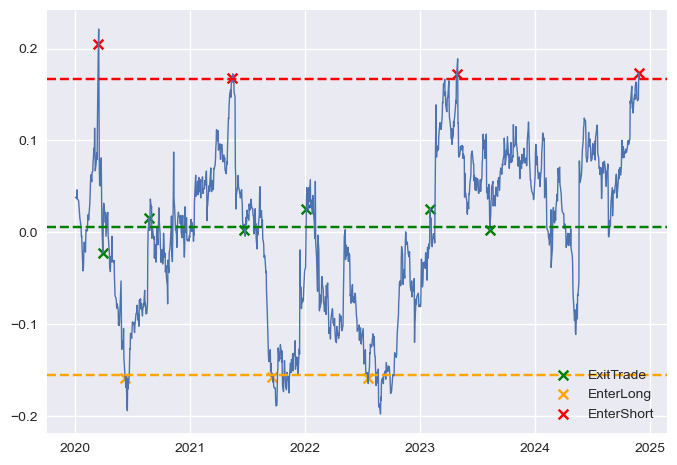

In [22]:
""" Notebook Reference A """

# Reverse procedure
EG_2_reverse = BivariateEngleGranger()

EG_2_reverse.initialise_single_procedure(ticker_2_b, ticker_2_a, start_date_2, end_date_2)

EG_2_reverse.run_single_procedure(include_strategy_backtest=False)

## Appendix B

Full procedure for UNP on CSX sourced from *[Notebook Reference B]*:

Price regression summary 


Regressand Regressor  Coefficient  Standard Error  t-statistic  \
0        UNP  Constant     0.074419        0.011275     6.600476   
1        UNP       CSX     0.887748        0.008471   104.796734   

   p-value (t-dist)  
0      6.070744e-11  
1      0.000000e+00



Timeseries plots


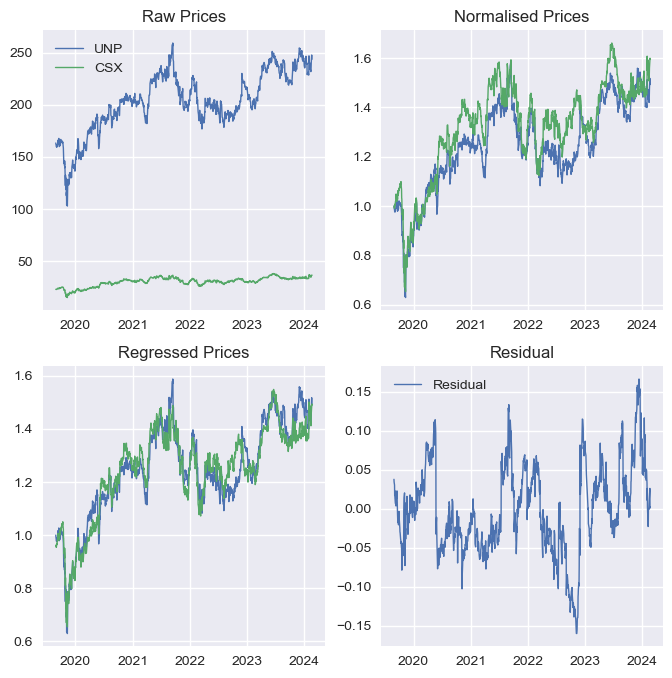



Cointegrated Augmented Dickey-Fuller test 


Regressand          Regressor  t-statistic Significance Level  \
0  ΔResidual  (Lag 1, Residual)    -3.958172                 1%   
1  ΔResidual  (Lag 1, Residual)    -3.958172                 5%   
2  ΔResidual  (Lag 1, Residual)    -3.958172                10%   

   Critical Value  Is Stationary  
0       -3.905337           True  
1       -3.341086           True  
2       -3.047889           True



Error Correction Model fitting 


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0       ΔUNP                ΔCSX     0.690572        0.016600    41.601797   
1       ΔUNP  (Lag 1, Residuals)    -0.026213        0.006331    -4.140155   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000037               True



Error Correction Model reverse fitting 


Regressand           Regressor  Coefficient  Standard Error  t-statistic  \
0       ΔCSX                ΔUNP     0.845628        0.020327    41.601797   
1       ΔCSX  (Lag 1, Residuals)     0.026151        0.007015     3.727678   

   p-value (t-dist)  Significant at 5%  
0          0.000000               True  
1          0.000202               True



Fit to Ornstein-Uhlenbeck Stochastic Differential Equation 
Theta: 7.1829

Half-life in years: 0.0965 years
Half-life in working days: 24.3179 days

Equilibrium level μ_e: -0.0010107871231991512
Equilibirum level μ_e can be compared to the AR(1) fitting intercept: -2.8404286893590073e-05

Sum Squared Errors: 0.21430789588363944

Annualised Variance: 0.0008504281582684104
Diffusion in Ornstein-Uhlenbeck SDE (sigma_ou): 0.4695470870108148
Diffusion in equilibrium to dictate entry trade signals (sigma_eq): 0.12388376755513551

Diffusion of sample residuals (note the difference): 0.013173027770202485


Grid search optimisation results for Z 
Maximum return occurs with Z=0.55


Z  Total Trades  Total Return
0   0.30            18      1.610532
1   0.35            17      1.680343
2   0.40            16      1.684594
3   0.45            16      1.999337
4   0.50            15      1.977045
5   0.55            15      2.169896
6   0.60            12      1.665037
7   0.65             9      1.067648
8   0.70             8      1.062840
9   0.75             8      1.146534
10  0.80             8      1.190835
11  0.85             6      0.870548
12  0.90             6      0.899229
13  0.95             3      0.431091
14  1.00             3      0.436525
15  1.05             3      0.459070
16  1.10             2      0.316727
17  1.15             2      0.318599
18  1.20             2      0.329117
19  1.25             2      0.337375
20  1.30             1      0.126249
21  1.35             1      0.126249
22  1.40             0      0.000000



Backtest plots for optimal Z


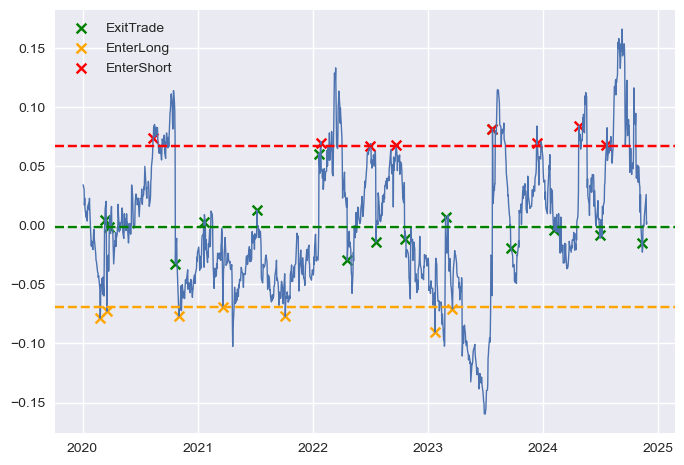

In [23]:
""" Notebook Reference B """

# Reverse procedure
EG_3_reverse = BivariateEngleGranger()

EG_3_reverse.initialise_single_procedure(ticker_3_b, ticker_3_a, start_date_3, end_date_3)

EG_3_reverse.run_single_procedure(include_strategy_backtest=False)